# Store Sales Forecasting: Ecuador

In [193]:
import polars as pl 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import glob 
import os 

* Let's read in all files using glob as opposed to read_csv

In [194]:
directory_path = '/Users/jack/Desktop/Data Analysis Practice/Kaggle/Store Sales Time Series/store-sales-time-series-forecasting'

In [195]:
csvs = os.path.join(directory_path,'*.csv')

all_files = glob.glob(csvs)

In [196]:
data_dict = {}

for i, file in enumerate(all_files): 

    #read csv 
    df = pl.read_csv(file
                     ,try_parse_dates=True)

    #pull file name 
    df_name = all_files[i].split('/')[-1].split('.')[0]

    data_dict[df_name] = df

    print(f'Successfully Read in {df_name} data....')

Successfully Read in test data....
Successfully Read in train data....
Successfully Read in transactions data....
Successfully Read in oil data....
Successfully Read in holidays_events data....
Successfully Read in sample_submission data....
Successfully Read in stores data....


In [197]:
data_dict['train'], data_dict['test'] 

(shape: (3_000_888, 6)
 ┌─────────┬────────────┬───────────┬────────────────────────────┬──────────┬─────────────┐
 │ id      ┆ date       ┆ store_nbr ┆ family                     ┆ sales    ┆ onpromotion │
 │ ---     ┆ ---        ┆ ---       ┆ ---                        ┆ ---      ┆ ---         │
 │ i64     ┆ date       ┆ i64       ┆ str                        ┆ f64      ┆ i64         │
 ╞═════════╪════════════╪═══════════╪════════════════════════════╪══════════╪═════════════╡
 │ 0       ┆ 2013-01-01 ┆ 1         ┆ AUTOMOTIVE                 ┆ 0.0      ┆ 0           │
 │ 1       ┆ 2013-01-01 ┆ 1         ┆ BABY CARE                  ┆ 0.0      ┆ 0           │
 │ 2       ┆ 2013-01-01 ┆ 1         ┆ BEAUTY                     ┆ 0.0      ┆ 0           │
 │ 3       ┆ 2013-01-01 ┆ 1         ┆ BEVERAGES                  ┆ 0.0      ┆ 0           │
 │ 4       ┆ 2013-01-01 ┆ 1         ┆ BOOKS                      ┆ 0.0      ┆ 0           │
 │ …       ┆ …          ┆ …         ┆ …                  

In [198]:
#join holidays to stores given they are regional/national

hol_stores =  data_dict['stores'].join(
    data_dict['holidays_events'] 
                         .select(pl.col('locale_name','locale','transferred','date','type')),
                         left_on=['state'],
                         right_on=['locale_name'],
                        )

In [199]:
for key in data_dict.keys(): 
    print(f'Null Values in {key} data')
    print(data_dict[key].null_count())

Null Values in test data
shape: (1, 5)
┌─────┬──────┬───────────┬────────┬─────────────┐
│ id  ┆ date ┆ store_nbr ┆ family ┆ onpromotion │
│ --- ┆ ---  ┆ ---       ┆ ---    ┆ ---         │
│ u32 ┆ u32  ┆ u32       ┆ u32    ┆ u32         │
╞═════╪══════╪═══════════╪════════╪═════════════╡
│ 0   ┆ 0    ┆ 0         ┆ 0      ┆ 0           │
└─────┴──────┴───────────┴────────┴─────────────┘
Null Values in train data
shape: (1, 6)
┌─────┬──────┬───────────┬────────┬───────┬─────────────┐
│ id  ┆ date ┆ store_nbr ┆ family ┆ sales ┆ onpromotion │
│ --- ┆ ---  ┆ ---       ┆ ---    ┆ ---   ┆ ---         │
│ u32 ┆ u32  ┆ u32       ┆ u32    ┆ u32   ┆ u32         │
╞═════╪══════╪═══════════╪════════╪═══════╪═════════════╡
│ 0   ┆ 0    ┆ 0         ┆ 0      ┆ 0     ┆ 0           │
└─────┴──────┴───────────┴────────┴───────┴─────────────┘
Null Values in transactions data
shape: (1, 3)
┌──────┬───────────┬──────────────┐
│ date ┆ store_nbr ┆ transactions │
│ ---  ┆ ---       ┆ ---          │
│ u32  ┆ u

In [200]:
#before joining the data lets handle nulls in the oil prices 

data_dict['oil'].filter(pl.col('dcoilwtico').is_null()) # values don't seem to follow a pattern 


#lets visualize these 

data_dict['oil'].plot.line(x='date',
                           y='dcoilwtico',)


#given the small gaps, we can forward fill or interpolate and move on... 

data_dict['oil'].interpolate().plot.line(x='date',
                           y='dcoilwtico')

:Curve   [date]   (dcoilwtico)

In [201]:
#lets join our datasets together 

df = (data_dict['train']
 
 .join(data_dict['stores'],
                        on='store_nbr',
                        )

                        .join(
                            data_dict['oil'].interpolate().fill_null(strategy='backward'), # backfill the first day of missing values 
                            on='date',
                            how='left'
                        )
                        
                        )

# analysis amongst groups: 

    * lets first look across our different product families, clusters and store types for differences in our target (sales)

In [202]:
data_dict['test']['family'].unique(), data_dict['train']['family'].unique()

(shape: (33,)
 Series: 'family' [str]
 [
 	"HOME AND KITCHEN I"
 	"GROCERY II"
 	"BABY CARE"
 	"MAGAZINES"
 	"EGGS"
 	…
 	"SCHOOL AND OFFICE SUPPLIES"
 	"FROZEN FOODS"
 	"HOME AND KITCHEN II"
 	"LADIESWEAR"
 	"AUTOMOTIVE"
 ],
 shape: (33,)
 Series: 'family' [str]
 [
 	"BOOKS"
 	"CLEANING"
 	"MAGAZINES"
 	"LAWN AND GARDEN"
 	"LADIESWEAR"
 	…
 	"LIQUOR,WINE,BEER"
 	"PLAYERS AND ELECTRONICS"
 	"GROCERY II"
 	"BEAUTY"
 	"PERSONAL CARE"
 ])

In [203]:
df = df.with_columns((pl.when(pl.col('onpromotion') > 0) # create flag to represent on sale 
                .then(1)
                .otherwise(0)).alias('on_sale')
                )

In [204]:
df.group_by('on_sale').agg(pl.col('sales').mean()) # looks like a huge potential sales lift 

shape: (2, 2)
┌─────────┬────────────┐
│ on_sale ┆ sales      │
│ ---     ┆ ---        │
│ i32     ┆ f64        │
╞═════════╪════════════╡
│ 1       ┆ 1137.69373 │
│ 0       ┆ 158.246681 │
└─────────┴────────────┘

family
BOOKS                            0.070797
BABY CARE                        0.110528
HOME APPLIANCES                  0.457476
HARDWARE                         1.137833
MAGAZINES                        2.929082
SCHOOL AND OFFICE SUPPLIES       2.961599
BEAUTY                           3.715723
PET SUPPLIES                     3.921263
LAWN AND GARDEN                  6.035475
AUTOMOTIVE                       6.101236
PLAYERS AND ELECTRONICS          6.186857
LADIESWEAR                       7.160629
LINGERIE                         7.182128
CELEBRATION                      8.370469
HOME AND KITCHEN II             16.722420
HOME AND KITCHEN I              20.470342
GROCERY II                      21.584048
SEAFOOD                         22.163190
LIQUOR,WINE,BEER                85.187824
PREPARED FOODS                  96.770202
FROZEN FOODS                   154.766954
EGGS                           171.420516
HOME CARE                      176.198029
DELI                       

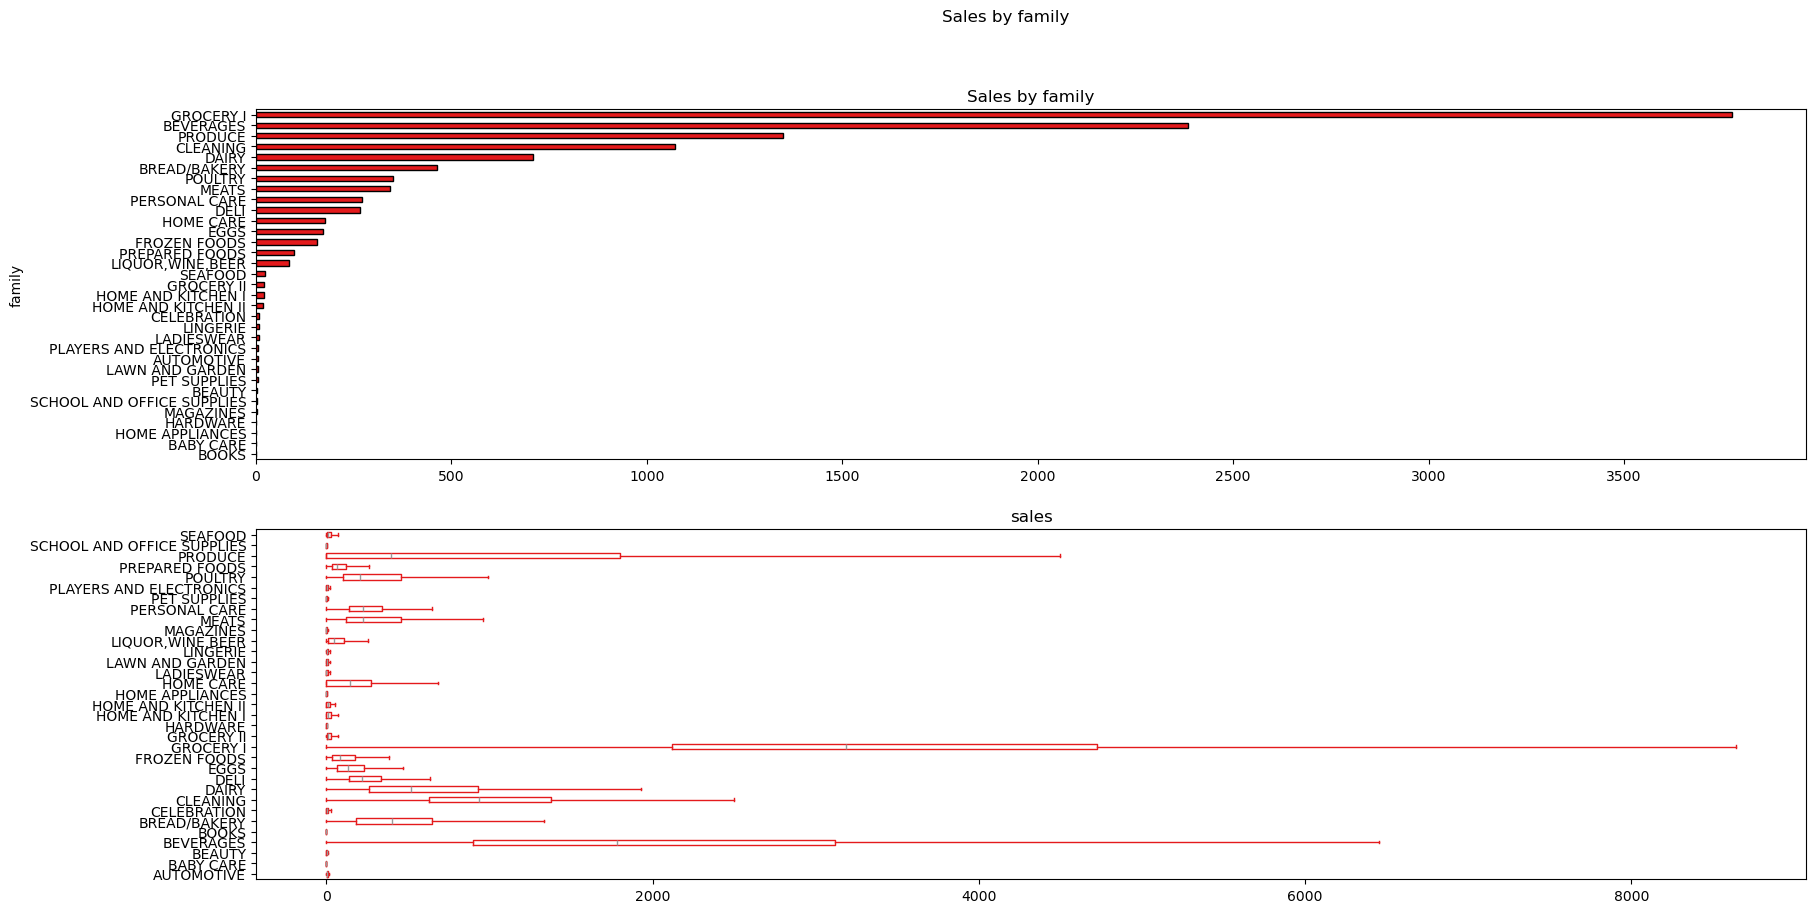

city
Puyo              73.601845
Manta            125.173982
Playas           138.139340
Latacunga        190.583961
El Carmen        198.975799
Riobamba         204.921881
Salinas          205.517129
Ibarra           206.061866
Santo Domingo    214.942315
Guaranda         234.821670
Quevedo          255.137503
Libertad         275.722146
Guayaquil        276.594464
Cuenca           294.924279
Esmeraldas       294.963151
Machala          300.392253
Babahoyo         319.349181
Loja             339.379530
Daule            345.282181
Ambato           362.632273
Cayambe          509.709179
Quito            556.577090
Name: sales, dtype: float64

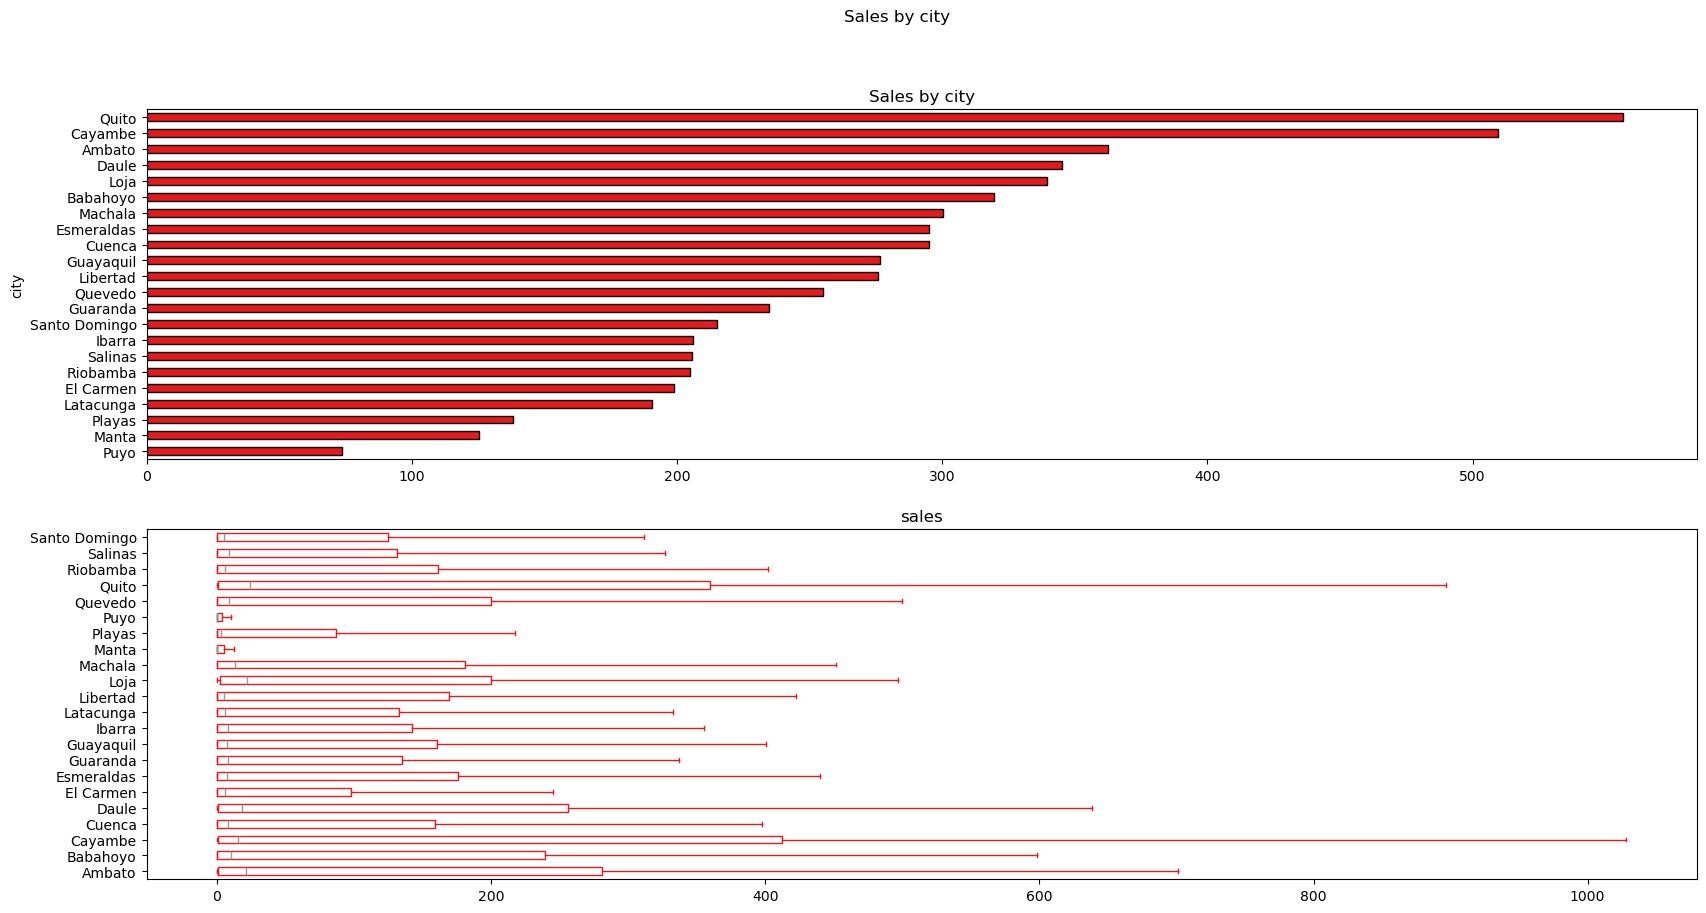

state
Pastaza                            73.601845
Manabi                            149.774588
Cotopaxi                          190.583961
Chimborazo                        204.921881
Santa Elena                       205.517129
Imbabura                          206.061866
Santo Domingo de los Tsachilas    214.942315
Bolivar                           234.821670
Guayas                            270.172671
Los Rios                          287.243342
Azuay                             294.924279
Esmeraldas                        294.963151
El Oro                            300.392253
Loja                              339.379530
Tungurahua                        362.632273
Pichincha                         554.110358
Name: sales, dtype: float64

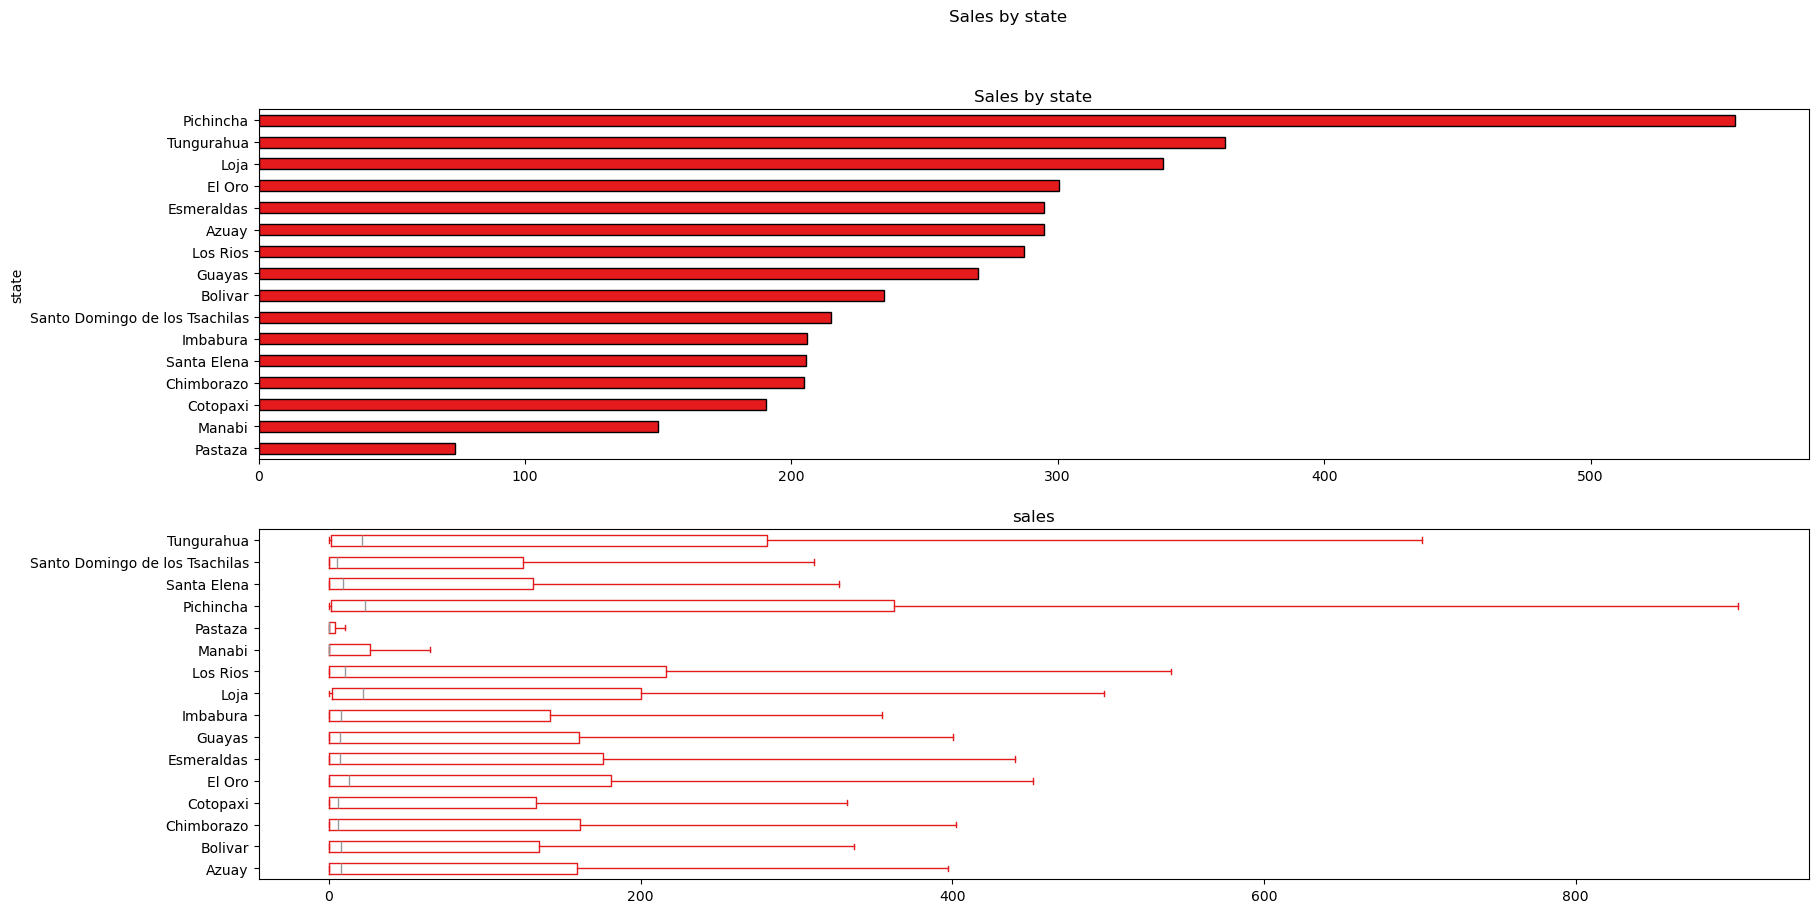

type
C    197.263301
E    269.121301
B    326.739714
D    350.979407
A    705.878743
Name: sales, dtype: float64

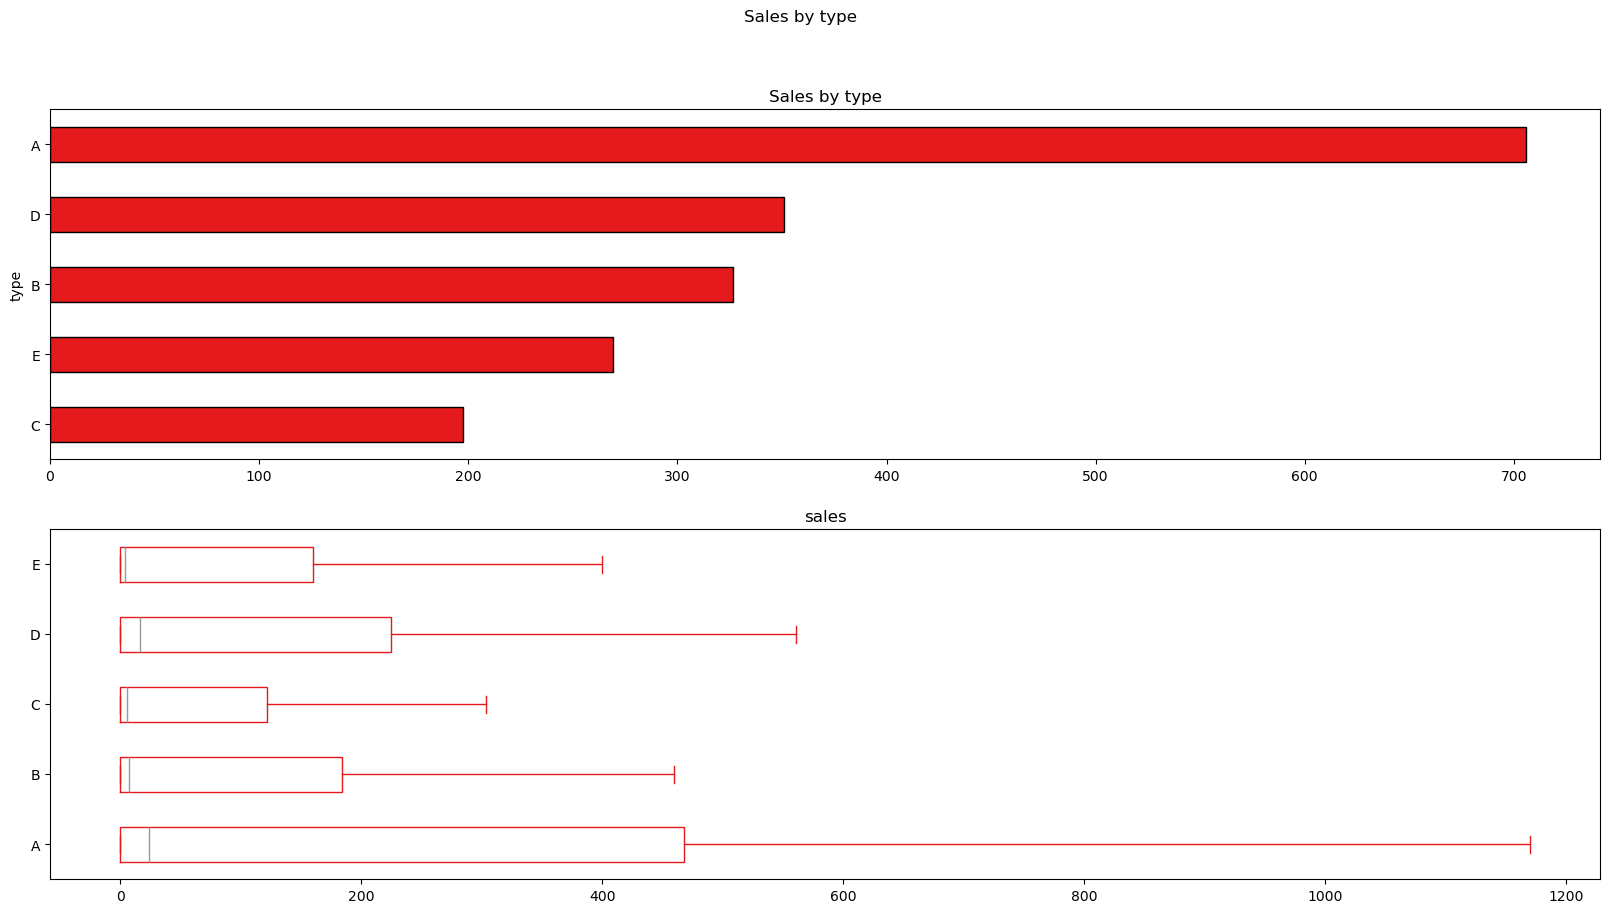

cluster
7      139.261863
3      194.416262
15     199.010111
16     238.598137
10     255.897546
2      260.170621
9      274.968339
4      296.572872
13     324.364108
12     324.461406
1      326.163967
6      342.661732
17     592.231511
11     603.507018
8      647.377856
14     708.227718
5     1117.245254
Name: sales, dtype: float64

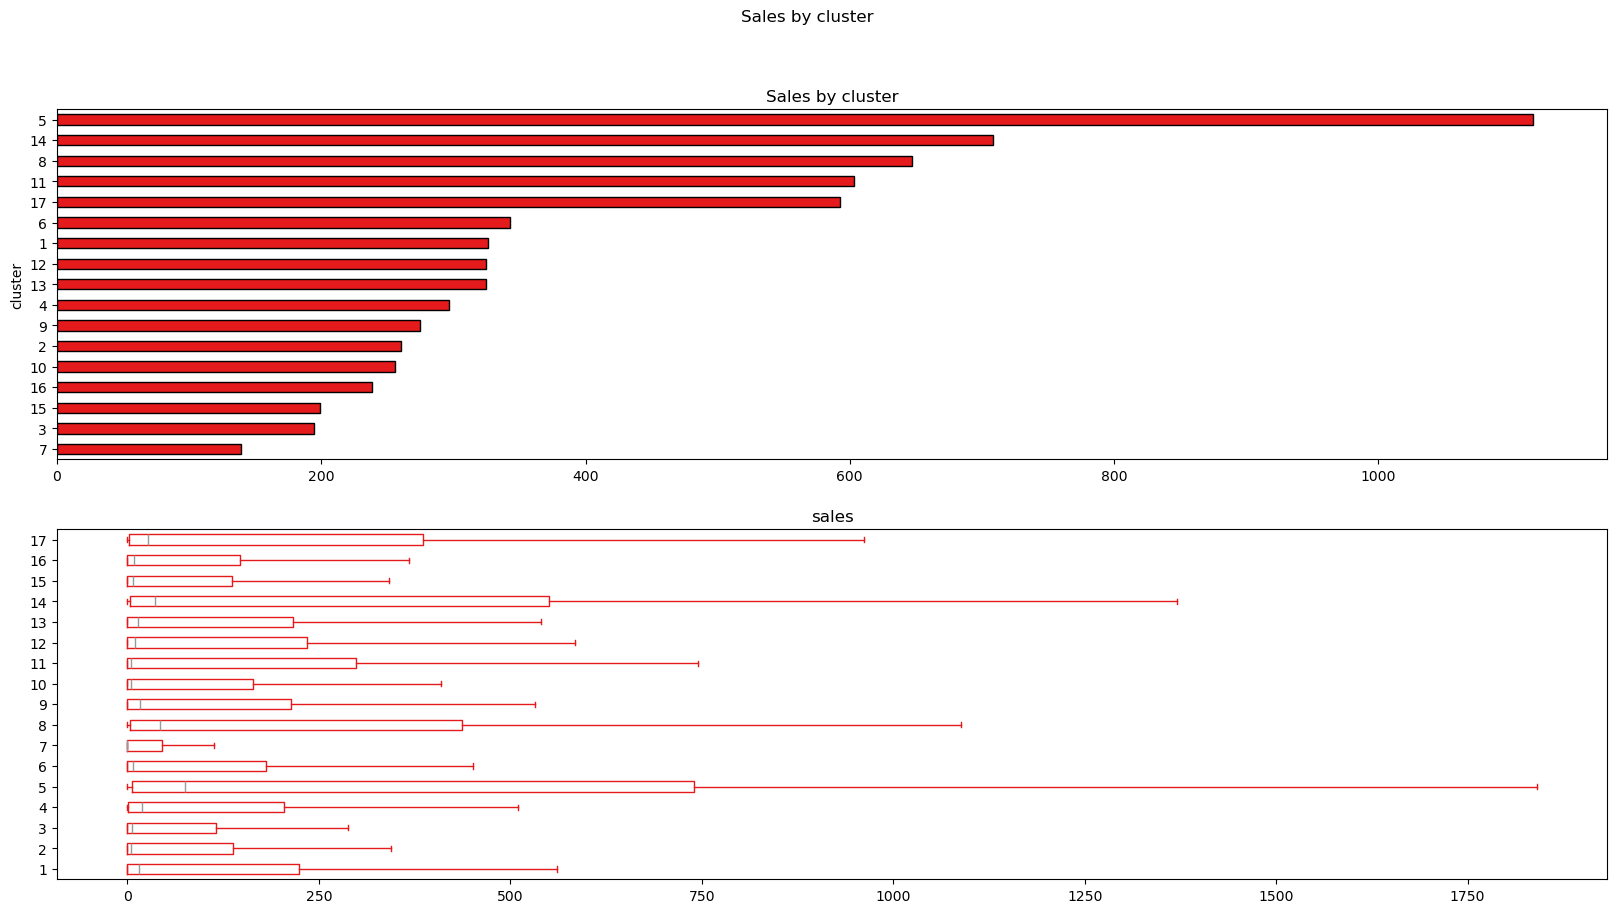

In [205]:
for category in df.select(pl.col(pl.String)).columns + ['cluster']: 

    display(df.to_pandas().groupby(category)['sales'].mean().sort_values()) # it looks like we have some very sparse categories given mean sales

    fig, ax = plt.subplots(figsize=(20,10),
    nrows=2)

    df.to_pandas().groupby(category)['sales'].mean().sort_values().plot.barh(title=f'Sales by {category}',
                                                                             ax=ax[0],
                                                                             cmap='Set1',
                                                                             edgecolor='black')
    
    df.to_pandas().plot.box(column='sales',
                            by=category,
                title=f'Sales by {category}',
                ax=ax[1],
                cmap='Set1',
                showfliers=False,
                vert=False)
                    
    plt.show()


<Axes: >

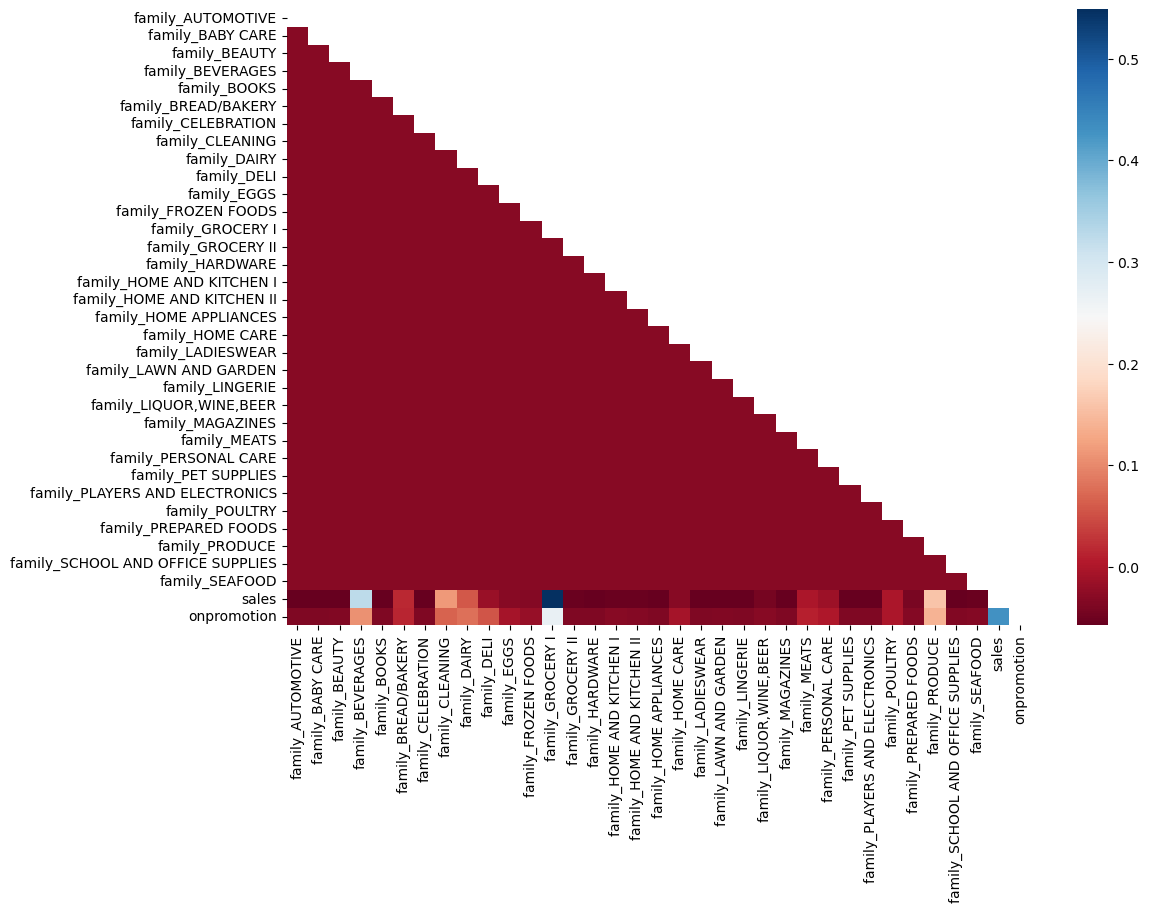

In [206]:
plt.figure(figsize=(12,8))

#it looks like we have lots of very sparse categories. Lets look at how some of our smaller cateogries sell on promotion 

import seaborn as sns 

corr = pl.concat([df.select(pl.col('family')).to_dummies(),df.select(['sales','onpromotion'])],how='horizontal').to_pandas().corr()


mask = np.triu(np.ones_like(corr))

sns.heatmap(corr,
            mask=mask,
            annot=False,
            cmap='RdBu') # it looks like there is a small relationship between grocery and sales (makes sense), as well as family produce 

* lets now look at how oil price relates to our sales 

In [207]:
from statsmodels.graphics.tsaplots import plot_ccf
from statsmodels.tsa.stattools import grangercausalitytests 

daily = df.group_by_dynamic(
    'date',
    every='1d',

).agg(pl.col(['sales']).sum(),
      pl.col('dcoilwtico').mean())


daily = daily.with_columns(pl.col('dcoilwtico').interpolate())

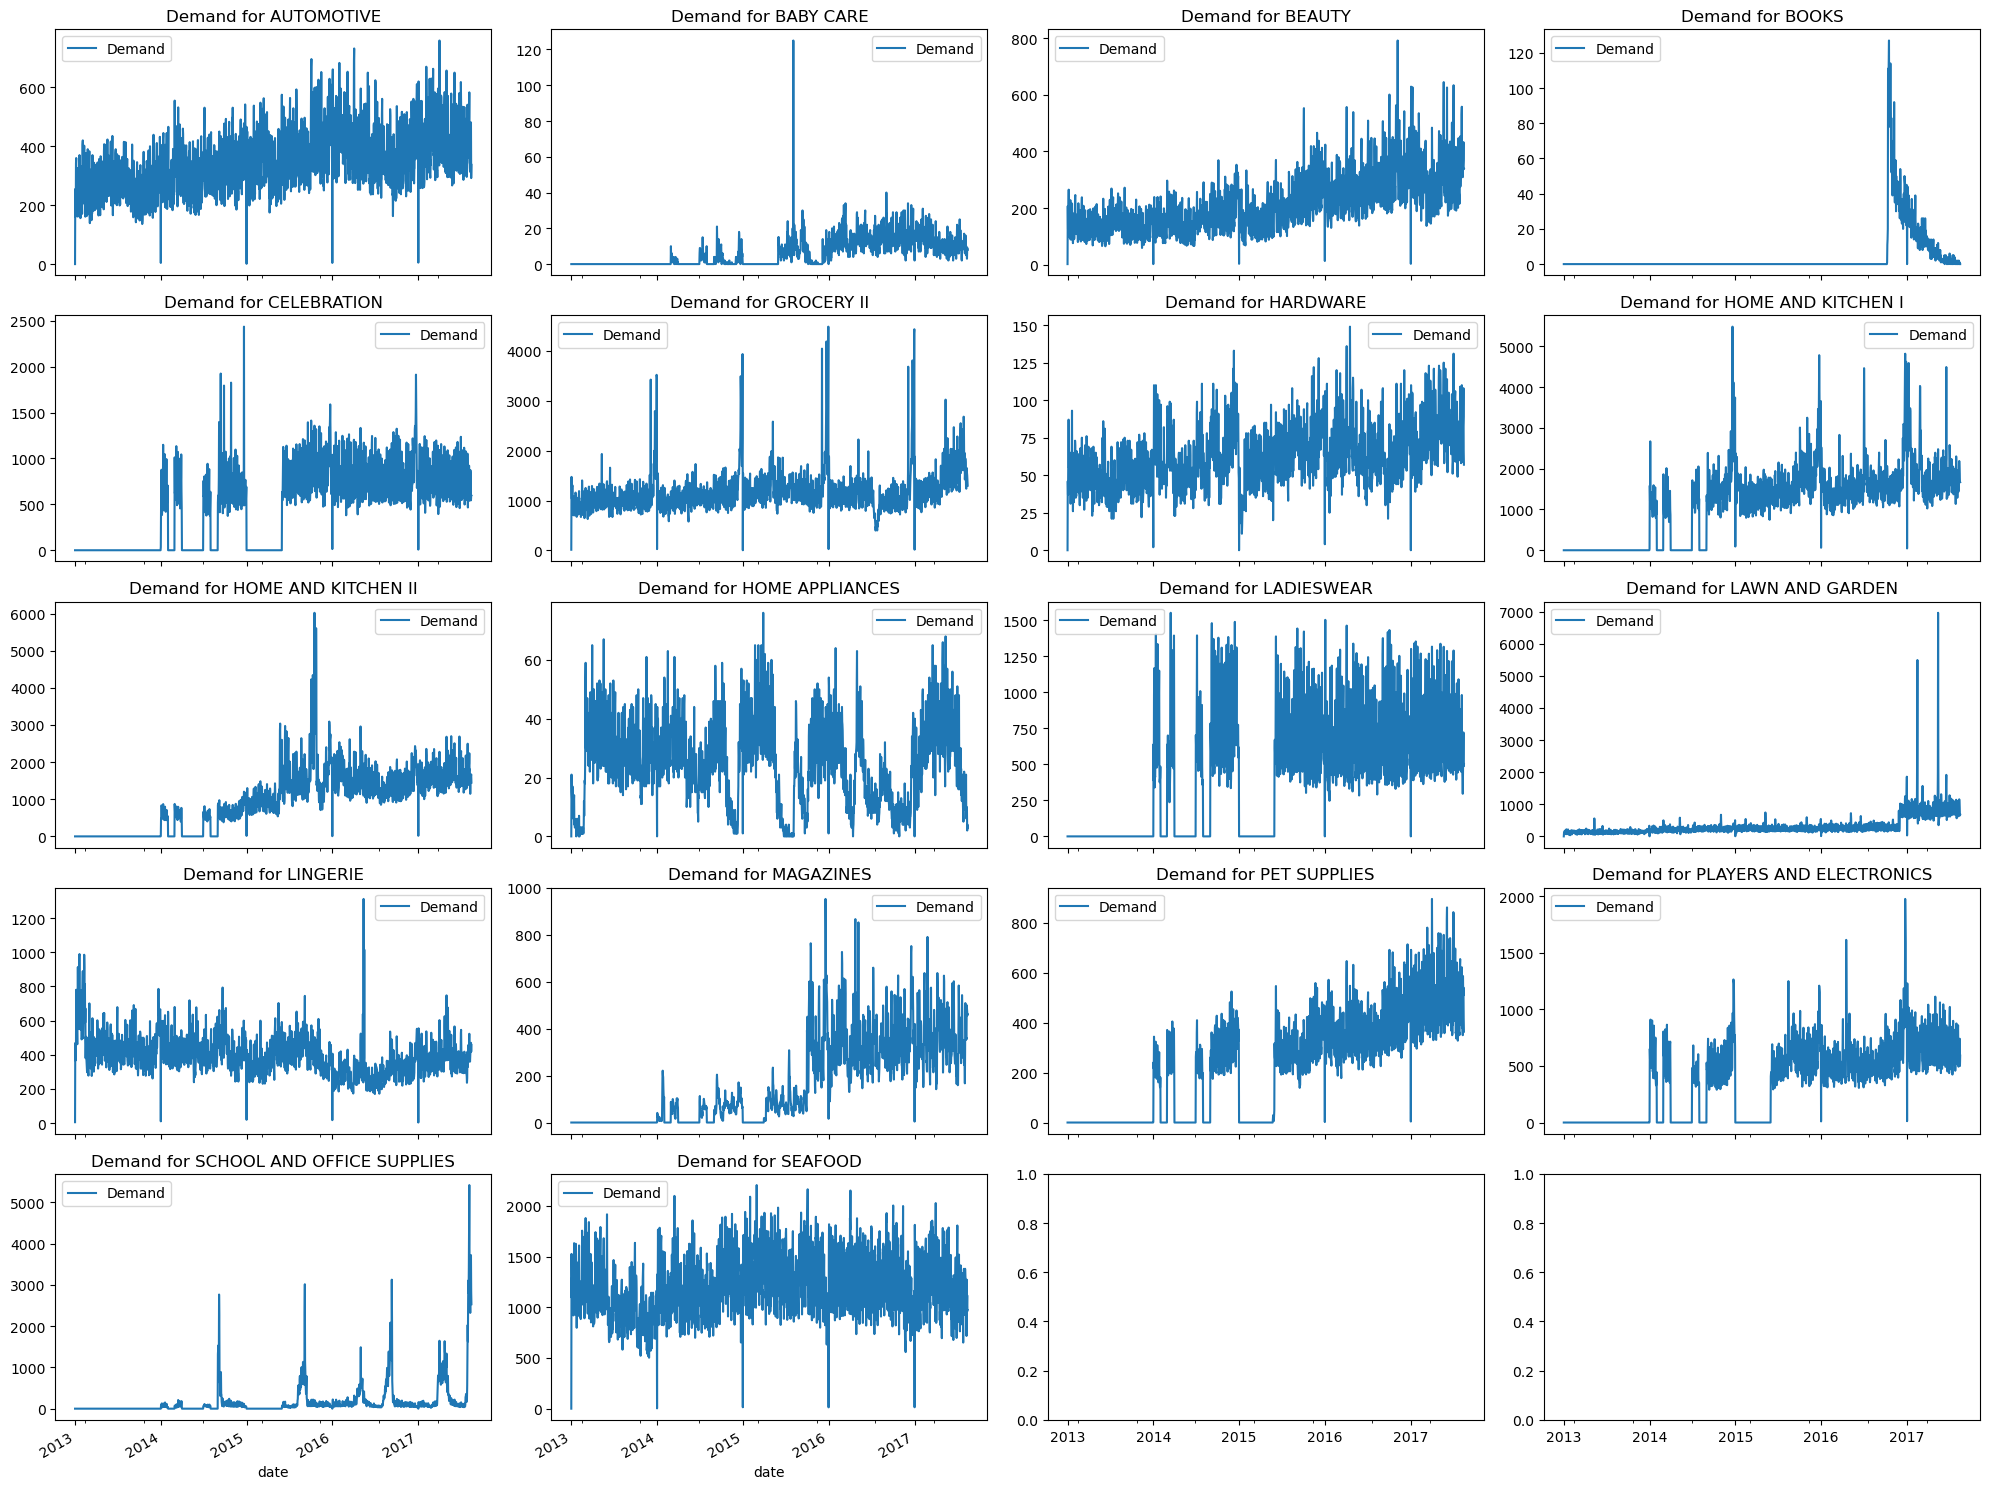

In [208]:
dogs = df.group_by(pl.col('family')).agg(pl.col(['sales']).mean()).sort('sales')[:18]['family'].unique() # these product families are signifcantly slow movers, lets filter our df for them and inspect


slow_movers = (df.filter(pl.col('family').is_in(dogs))

.group_by_dynamic('date',
    every='1d',
    group_by='family').agg(pl.col('sales').sum())).to_pandas()

fig, ax = plt.subplots(figsize=(20,15),
ncols=4,
nrows=5,
sharex=True)

ax = ax.flatten()

for i, fam in enumerate(slow_movers.family.unique()):

    sub = slow_movers.query(f"family == '{fam}'").plot(title=f'Demand for {fam}',
                                                     x='date',
                                                     y='sales',
                                                     label='Demand',
                                                     ax=ax[i]) 


plt.tight_layout()

<Axes: title={'center': 'Oil Price at First Difference'}>

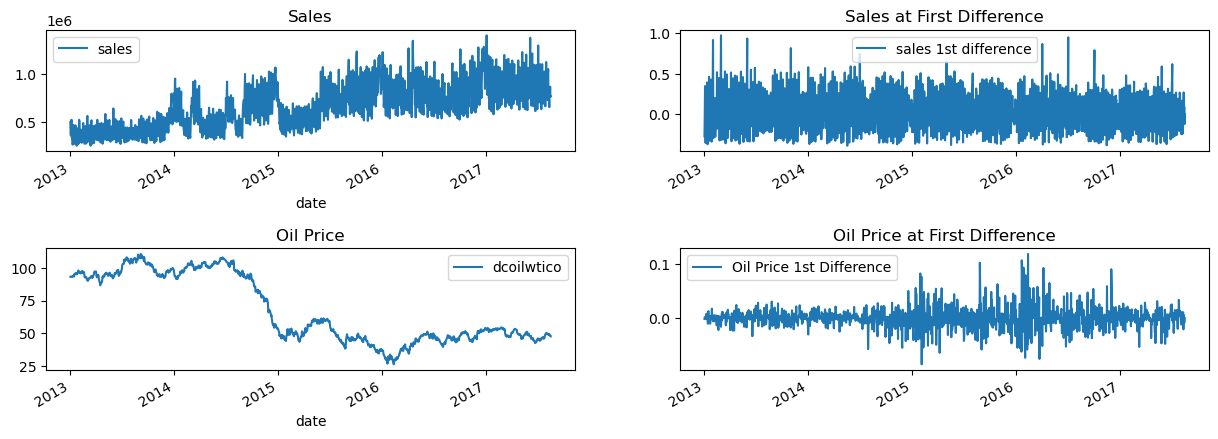

In [209]:
ts = daily.to_pandas().set_index('date').query('date.dt.day != 1') # pull out the first day of the month to eliminate outliers

fig, ax = plt.subplots(figsize=(15,10),
ncols=2,
nrows=2)

ax = ax.flatten() 

ts.plot(
        y='sales',
        figsize=(15,5),
        ax=ax[0],
        title='Sales') # series is not stationary here 

ts.pct_change().dropna().plot(
                        y='sales',
                        label='sales 1st difference',
                        ax=ax[1],
                        title='Sales at First Difference',
                        xlabel='')


ts.plot(
        y='dcoilwtico',
        figsize=(15,5),
        ax=ax[2],
        title='Oil Price') # series is not stationary here 

fig.subplots_adjust(hspace=.8)

ts.pct_change().dropna().plot(
                        y='dcoilwtico',
                        label='Oil Price 1st Difference',
                        ax=ax[3],
                        title='Oil Price at First Difference',
                        xlabel='')

# it looks like we have store closures at the end/beginning of year

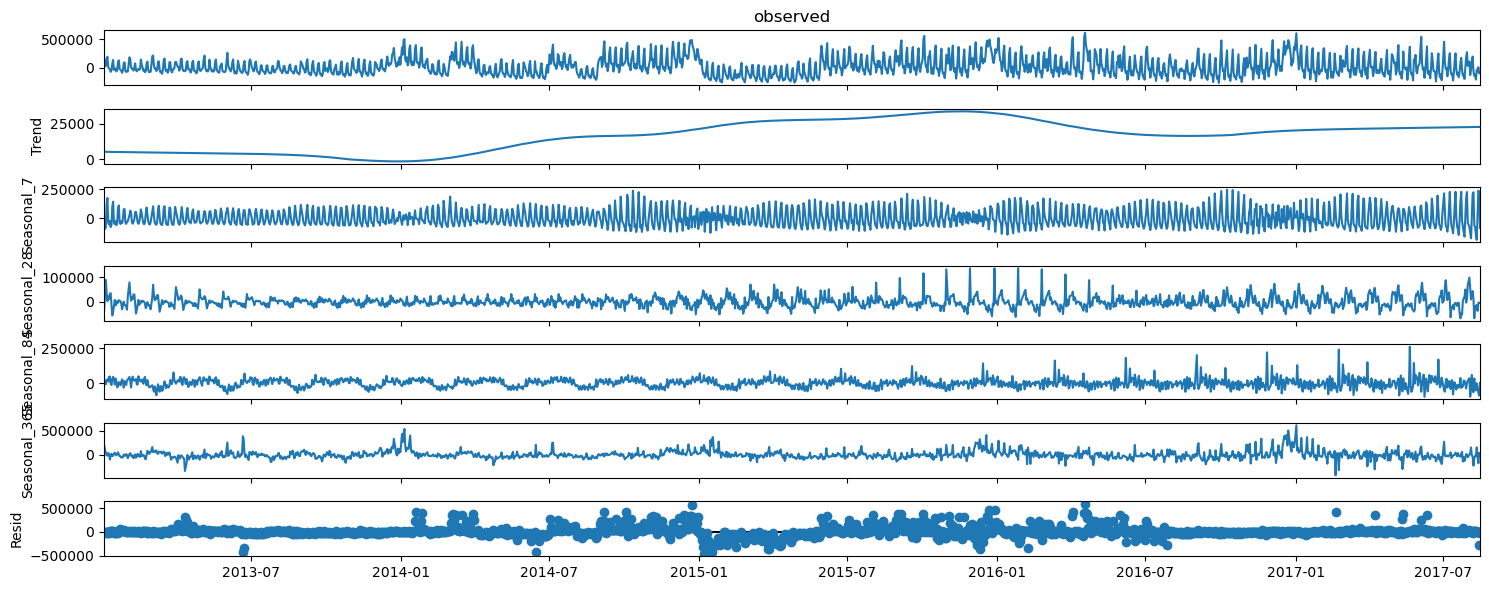

In [210]:
# first we detrend the series, after experimentation MSTL doesn't do a great job of detrending

from statsmodels.nonparametric.smoothers_lowess import lowess

lowess_trend = lowess(
    endog = ts['sales'],
    exog = np.arange(0,len(ts['sales'])),
)[:,1]

ts = ts.assign(detrended_sales = ts['sales'] - lowess_trend)

#now decompose detrended series 
from statsmodels.tsa.seasonal import MSTL 

mstl_mod = MSTL(ts['detrended_sales'],
     periods=(7,28,28*3,365), # weekly, monthly, quarterly,yearly seasonality 
     #lmbda='auto', # apply boxcox transform 
     stl_kwargs={'trend_deg':0,
                 #'low_pass_deg':1,
                 'robust':True
                 }).fit()

plt.rc('figure',figsize=(15,6))

mstl_mod.plot()

plt.tight_layout()

/var/folders/k6/3y0j37d96lqf05r_8yyfcqvh0000gn/T/ipykernel_60116/1727177288.py:7: UserWarning:

The figure layout has changed to tight



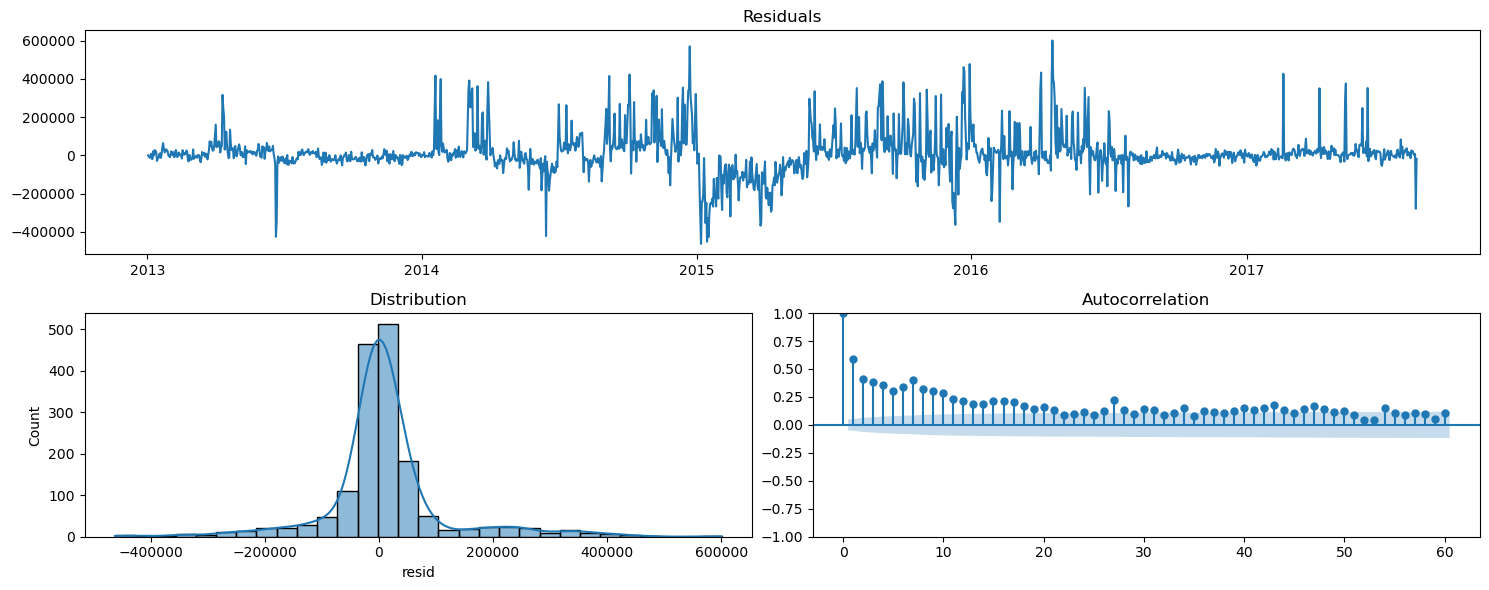

In [211]:
# we see some key change points in the series, even when accounting for deterministic trend and multiple seasonalities, lets plot residuals 

from skforecast.plot import plot_residuals

plot_residuals(mstl_mod.resid)

plt.tight_layout()

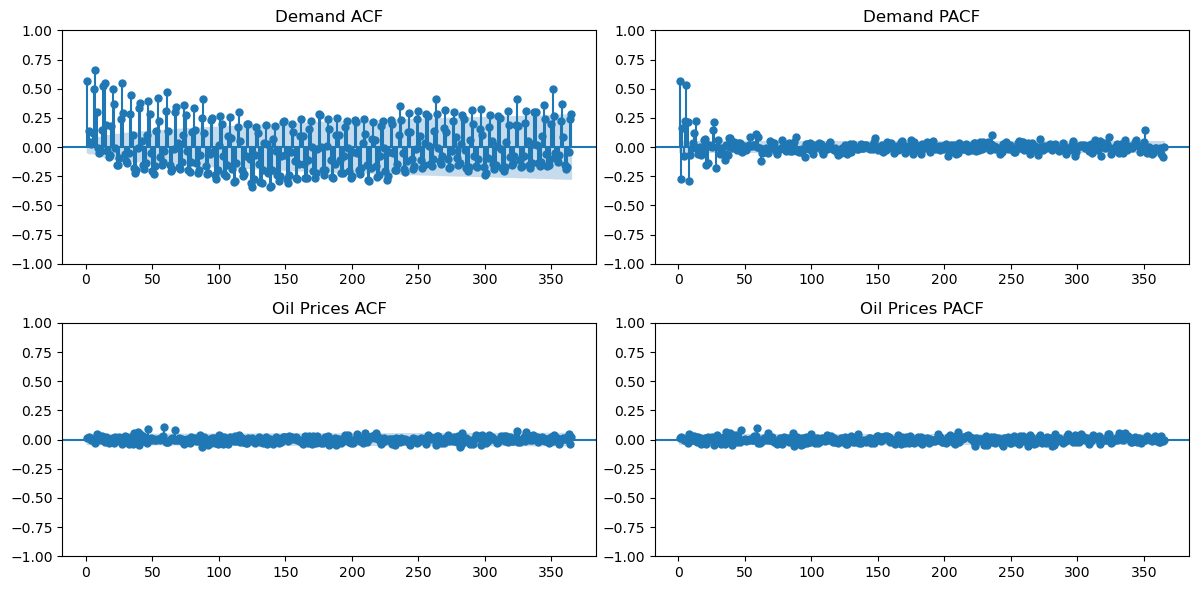

In [212]:
# lets look at acf and pacf of both sales and oil (we will have to forecast oil if we plan to use it as a covariate)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax  = plt.subplots(figsize=(12,6),
                        ncols = 2,
                        nrows=2)
ax = ax.flatten() 

diffd = ts.diff().dropna() 

plot_acf(ts['detrended_sales'],
         zero=False,
         lags=365,
         ax = ax[0],
         title='Demand ACF')

plot_pacf(ts['detrended_sales'],
         zero=False,
         lags=365,
         ax = ax[1],
         title='Demand PACF')

plot_acf(diffd['dcoilwtico'],
         zero=False,
         lags=365,
         ax = ax[2],
         title='Oil Prices ACF')

plot_pacf(diffd['dcoilwtico'],
         zero=False,
         lags=365,
         ax = ax[3],
         title='Oil Prices PACF')

fig.tight_layout()

With granger causality, it is important to look at the f statistics and the p value of a given lag you are testing, it looksl like quarterly and yearly lags could be significant. Note that we make the data stationary, or enforce "weak stationarity" before doing this... by transforming our data to pct_change

* does a pct change in oil granger-cause sales ? 

In [213]:
lags = [1,7,28,28*3,365]

new_ts = ts.assign(oil_diff = ts['dcoilwtico'].pct_change()).dropna()

granger_res = grangercausalitytests(new_ts[['detrended_sales','oil_diff']],
                      maxlag=lags
    )


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2439  , p=0.6215  , df_denom=1623, df_num=1
ssr based chi2 test:   chi2=0.2443  , p=0.6211  , df=1
likelihood ratio test: chi2=0.2443  , p=0.6211  , df=1
parameter F test:         F=0.2439  , p=0.6215  , df_denom=1623, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.8572  , p=0.5399  , df_denom=1605, df_num=7
ssr based chi2 test:   chi2=6.0566  , p=0.5332  , df=7
likelihood ratio test: chi2=6.0453  , p=0.5345  , df=7
parameter F test:         F=0.8572  , p=0.5399  , df_denom=1605, df_num=7

Granger Causality
number of lags (no zero) 28
ssr based F test:         F=0.8736  , p=0.6564  , df_denom=1542, df_num=28
ssr based chi2 test:   chi2=25.3647 , p=0.6079  , df=28
likelihood ratio test: chi2=25.1656 , p=0.6188  , df=28
parameter F test:         F=0.8736  , p=0.6564  , df_denom=1542, df_num=28

Granger Causality
number of lags (no zero) 84
ssr based F test:         F=1.4525  

In [214]:
for lag in lags: 
    
    print(f"F Statistics of Granger Test at Lag : {lag}: {granger_res[lag][0]['ssr_ftest'][0]:.5f}")

    p_val =  granger_res[lag][0]['ssr_ftest'][1]

    if p_val <= .05: 

        print(f'This lag is significant (95%) (Granger Causality) to our sales:')

    print()

F Statistics of Granger Test at Lag : 1: 0.24389

F Statistics of Granger Test at Lag : 7: 0.85721

F Statistics of Granger Test at Lag : 28: 0.87359

F Statistics of Granger Test at Lag : 84: 1.45251
This lag is significant (95%) (Granger Causality) to our sales:

F Statistics of Granger Test at Lag : 365: 1.17166
This lag is significant (95%) (Granger Causality) to our sales:



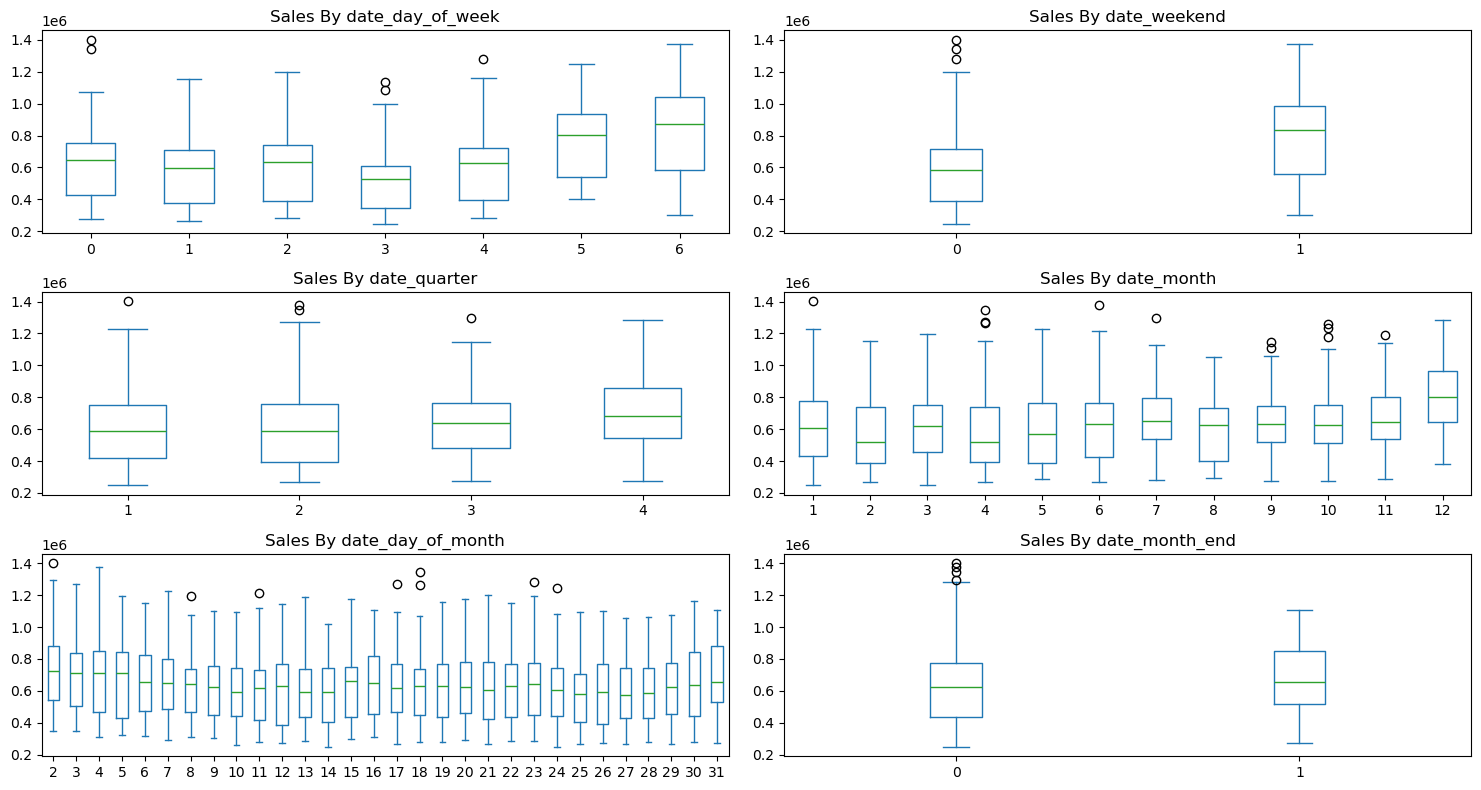

In [215]:
from feature_engine.datetime import DatetimeFeatures 

dtf = DatetimeFeatures(variables='date',
                       features_to_extract=['day_of_week','weekend','quarter','month','day_of_month','month_end'],
                       drop_original=False)

dt_feats = dtf.fit_transform(ts.reset_index())

fig, ax = plt.subplots(figsize=(15,8),
nrows= 3,
ncols=2)

ax = ax.flatten()

for i, date_feat in enumerate(dtf.get_feature_names_out()[4:]):

    dt_feats.plot.box(column='sales',
                      by=date_feat,
                      #title=f'Sales By {date_feat}',
                      ax=ax[i])
    

    ax[i].set_title(f'Sales By {date_feat}')
    

fig.tight_layout()

* now lets examine seasonality across multiple dimensions (example being weekly seasonality per month, etc)

Text(0.5, 1.0, 'Day of Month/Monthly')

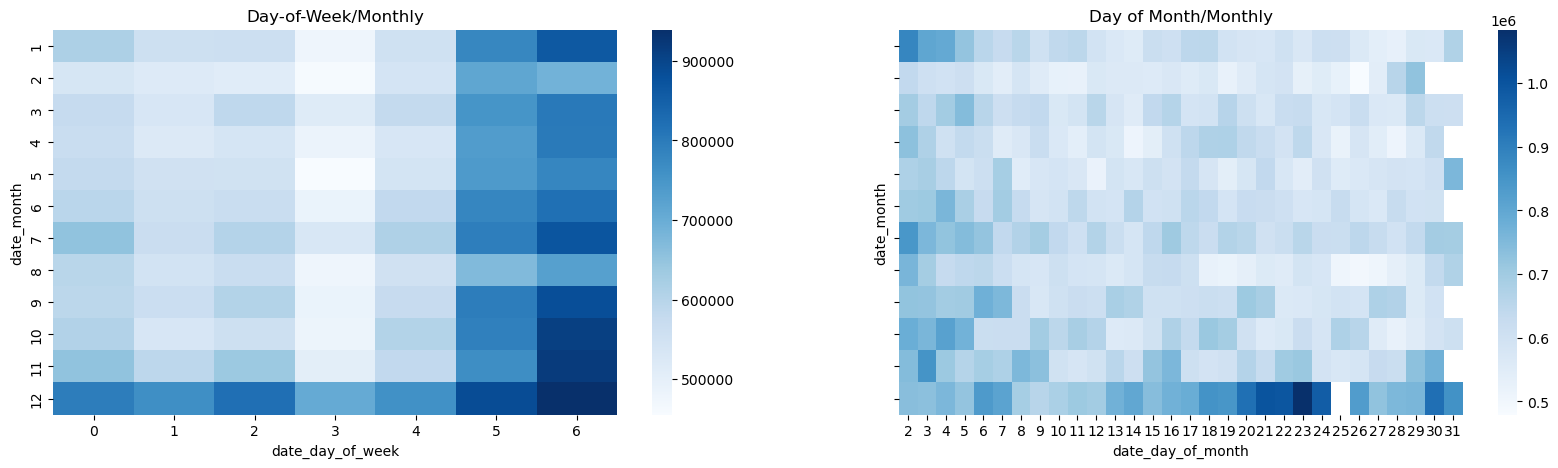

In [216]:
import plotly.express as px 

dow_month = dt_feats.pivot_table(columns='date_day_of_week',
               index='date_month',
               values='sales',
               aggfunc='mean')# it looks like sales pick up every Friday, Saturday and especially during Nov, Dec


dom_month = dt_feats.pivot_table(columns='date_day_of_month',
              index='date_month',
              values='sales',
               aggfunc='mean')

fig, ax = plt.subplots(figsize=(20,5),
ncols=2,
sharey=True)

sns.heatmap(dow_month,ax=ax[0],cmap='Blues').set_title('Day-of-Week/Monthly')

sns.heatmap(dom_month,ax=ax[1],
            cmap='Blues').set_title('Day of Month/Monthly')

# Now, doing some EDA around the holiday effect.

In [217]:
hol_stores = hol_stores.with_columns((pl.lit('holiday')).alias('is_holiday')) # add holiday flag 

new_df = df.join(
    hol_stores.select(pl.col(['type','date','store_nbr','is_holiday','locale','cluster'])),
    on=['type','date','store_nbr','cluster'],
    how='left'
)


tab = (new_df
 
 .group_by(
    
    ['type','is_holiday','locale'],
                              
                              maintain_order=True)

.agg(pl.col('sales').mean())

.fill_null('non_holiday')) # it looks like on average sales change but its a slight decrease in most regions 


px.bar(tab,
       x='type',
       y='sales',
       color='is_holiday',
       barmode='group',
       title='Mean Sales By Holiday/Non-Holiday + Holiday Locale',
       labels={'type':'Store Type',
               'sales':'Sales',
               'is_holiday':'Is It a Holiday?'},
               facet_col='locale')

#not the most elegant visual but we see regional holidays have a slight decrease on sales while local holidays have a lift on sales 

* constructing hierarchical dataset

In [218]:
df.select(pl.col('store_nbr','city')).unique()

#we get future promotions, everything aside from store number and product family are not required in the hierarchy but we can use them as features.... 

df = df.with_columns(pl.col('dcoilwtico').interpolate(),# interpolate the oil column in our polars df, remember it has very small gaps.
                (pl.lit('store_') + pl.col('store_nbr').cast(pl.String)).alias('store_nbr'))  # rename store number column for cleaner names 


In [219]:
df = df.with_columns((pl.col('family') + '-' + pl.col('store_nbr')).alias('uid')) # create uid column of Product Cat-Store, most supply chains plan at Product Level

In [220]:
df = df.rename({'uid':'unique_id',
           'date':'ds',
           'sales':'y'}) # rename columns for ease of use 

In [221]:
# define evaluation function 

from sklearn.metrics import mean_absolute_error, root_mean_squared_error


def wape(y_true,y_pred):
    mae = mean_absolute_error(y_true,y_pred)

    return mae/np.mean(y_true) # this is changed to mae % 

def forecast_bias(y_true,y_pred): 
    e = y_true - y_pred
    bias = np.sum(e) / np.sum(y_true)
    return bias * 100



def eval_func(x):

    return {'rmse':root_mean_squared_error(x['y'],x['y_pred']),
              'mae':mean_absolute_error(x['y'],x['y_pred']),
              'wape':wape(x['y'],x['y_pred']),
              'forecast_bias':forecast_bias(x['y'],x['y_pred'])}


#eval table generation, optional argument to return error distribution or aggregate error metrics for each model 

def eval_tab_gen(cv_df,model_name,return_type = 'agg'): 

    if return_type == "agg": 
            
        cv_res = cv_df.melt(id_vars=['unique_id','ds','cutoff','y'],
                    variable_name='forecast',
                    value_name='y_pred').to_pandas()\
                        .groupby('forecast').apply(eval_func)


        cv_tab = pd.json_normalize(cv_res)

        new_idx = [model_name + str(x) for x in cv_res.keys()]

        cv_tab.index = new_idx

        return cv_tab
    
    if return_type == 'dist': 

        cv_res = cv_df.melt(id_vars=['unique_id','ds','cutoff','y'],
                variable_name='forecast',
                value_name='y_pred').to_pandas()\
                    .groupby(['forecast','unique_id']).apply(eval_func)


        cv_tab = pd.json_normalize(cv_res)

        new_idx = [model_name + str(x) for x in cv_res.keys()]

        cv_tab.index = new_idx

        return cv_tab

In [222]:
tmp = (df.filter(pl.col('ds').dt.year() >= 2015)
       
       .with_columns((pl.when(pl.col('y')  ==0).then(1)
                                                               
                 .otherwise(0).alias("is_zero"))).with_columns(
                     
                 (pl.col('is_zero').sum()
                  
                  .over('family',pl.col('ds').dt.year(),pl.col('ds').dt.month())))

                    .sort('is_zero',descending=True))


max_zeros = tmp['is_zero'].max() # 1674 pertains to an entire month of no sales (dead category), lets filter these out of the dataset

print(f'THe number of zeros when a series had no demand: {max_zeros}')

new = tmp.filter(pl.col('is_zero') < 1674)

new_plot = new.filter(pl.col('family').is_in(dogs)).sort('ds').group_by_dynamic(index_column='ds',
                     every='1d',
                     group_by='family')\
                     .agg(pl.col('y').sum())


import plotly.express as px 

px.line(new_plot,
        x='ds',
        y='y',
        color='family',
        title='Plot of Sparse Series After Being Truncated: (Looks Much Better)')

dead_combos = new.group_by('unique_id').agg(pl.col('y').sum()).filter(pl.col('y') == 0)['unique_id'] # these item-store combinations don't exist so lets remove them.... 

new_df = new.filter(~pl.col('unique_id').is_in(dead_combos))  # filter out 

THe number of zeros when a series had no demand: 1674


In [223]:
# #first lets set some benchmarks using statistical univariate models 

from statsforecast import StatsForecast 
from statsforecast.models import SeasonalExponentialSmoothingOptimized, SeasonalNaive, CrostonOptimized, Naive 


#define forecast horizon 

horizon = 14 # 2 weeks 

models = [SeasonalExponentialSmoothingOptimized(season_length=365,
                  alias='seasonal_exp'),
                    Naive(alias='single_step_naive'),
                  SeasonalNaive(season_length=28,
                                alias='monthly_naive'),
                   SeasonalNaive(season_length=7,
                                 alias='weekly_naive')]


sf = StatsForecast(models=models,
                   n_jobs=-1,
                freq='1d')

#we can cross validate on the entire dataset, 
stats_cv = sf.cross_validation(h=horizon,
                    df=new_df.select(pl.col('unique_id','ds','y')), # these models generally don't need as much data, so truncate the dataspan for faster fitting 
                    n_windows=3,
                    refit=True,
                    step_size=horizon)

/var/folders/k6/3y0j37d96lqf05r_8yyfcqvh0000gn/T/ipykernel_60116/1482449656.py:3: DeprecationWarning:

`DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`

/var/folders/k6/3y0j37d96lqf05r_8yyfcqvh0000gn/T/ipykernel_60116/1482449656.py:9: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



<Axes: title={'center': 'RMSE/MAE by Forecasting Model: Statistical'}, xlabel='Error', ylabel='Forecast'>

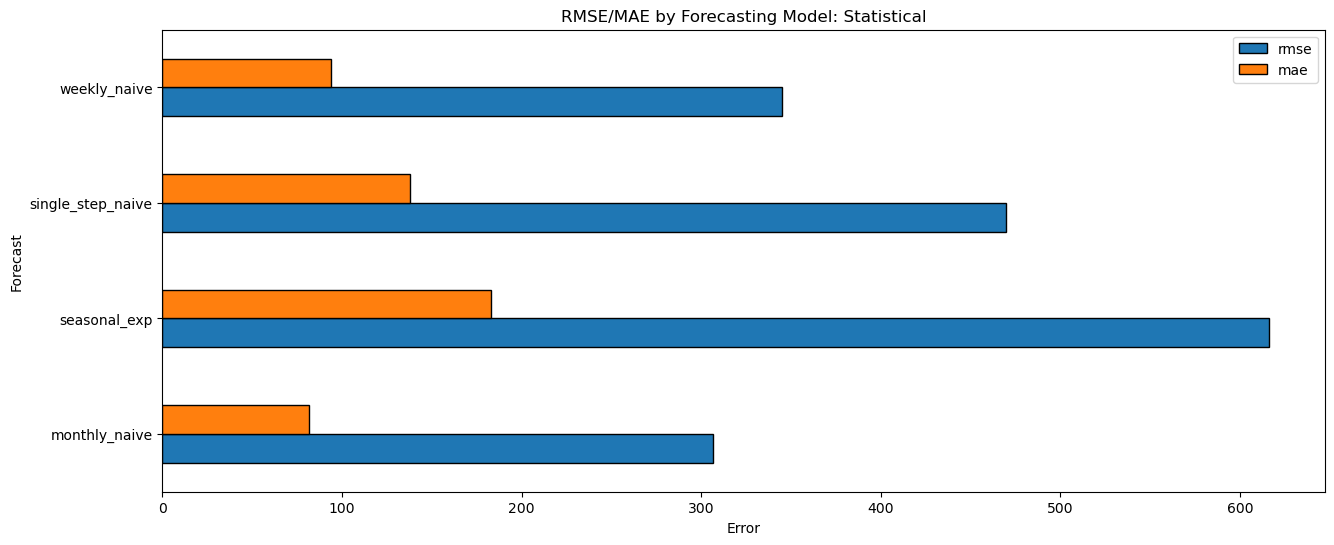

In [224]:
# # we have ~1780 unique timeseries 

stat_piv = stats_cv.melt(id_vars=['unique_id','ds','cutoff','y'],
                 variable_name='forecast',
                 value_name='y_pred')

# lets eval using rmse and mae 

stat_eval = stat_piv.to_pandas().groupby(['forecast']).apply(eval_func)


stat_eval_ = pd.json_normalize(stat_eval).set_index(stat_eval.keys())

stat_eval_.plot.barh(y=['rmse','mae'],
                     edgecolor='black',
                     xlabel='Error',
                     ylabel='Forecast',
                     title='RMSE/MAE by Forecasting Model: Statistical')

In [917]:
from mlforecast.target_transforms import Differences,LocalStandardScaler, LocalMinMaxScaler
from mlforecast.lag_transforms import ExponentiallyWeightedMean,ExpandingMean, RollingStd,RollingMean,SeasonalRollingMean
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor,XGBRFRegressor
from lightgbm import LGBMRegressor
from mlforecast import MLForecast
from catboost import CatBoostRegressor

mlf = MLForecast(models={'xgb': XGBRegressor(n_jobs=-1,
                                                objective='reg:squarederror'),   

                         'lgbm':LGBMRegressor(n_jobs=-1,
                                              verbosity=-1,
                                              random_state=42,
                                              ),         
                            'catboost':CatBoostRegressor(iterations=500,
                                                         random_state=42,
                                                         verbose=0),
                                              
                                              'RandomForest':XGBRFRegressor(random_state=42)},

             freq='1d',
             
    lags=[1,2,3,7,28],
    lag_transforms={
        1: [RollingMean(window_size=7,
                        min_samples=1)
            ]
    }, # supplying my own date feature pipeline
    date_features=['quarter',
                   'month',
                   'weekday',
                   'day'
                  #end_of_year
                   ], # create end of year dummy and year column 
    target_transforms=[])

In [918]:
from utilsforecast.feature_engineering import fourier, pipeline 
from functools import partial 

features = [partial(fourier, season_length=7,k=4),
            partial(fourier,season_length=28,k=3),
            partial(fourier,season_length=84,k=3)
            ]


new_df, fut_df = pipeline(df=new,
         features = features,
         h=horizon,
         freq='1d')

In [919]:
new_df = new_df.join(hol_stores
            
            .select(pl.col('store_nbr','city','state','date')).with_columns(pl.lit(True).alias('is_holiday'))
            
            .with_columns(('store_' + pl.col('store_nbr').cast(pl.String)).alias('store_nbr')),

            left_on=['ds','store_nbr','city','state'],

            right_on=['date','store_nbr','city','state'],

            how='left')\
                .with_columns(pl.col('is_holiday').fill_null(False).cast(int))

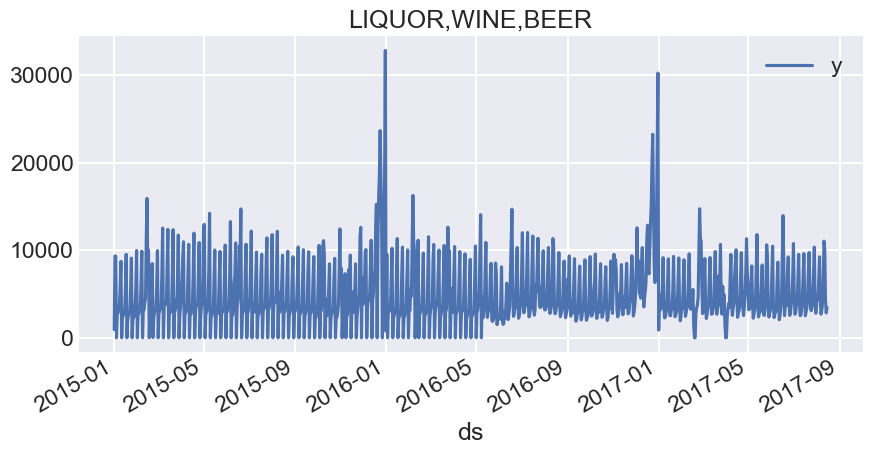

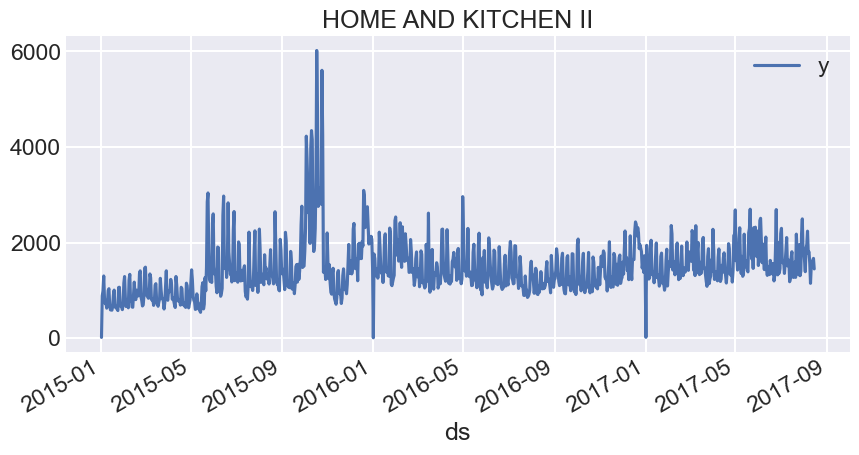

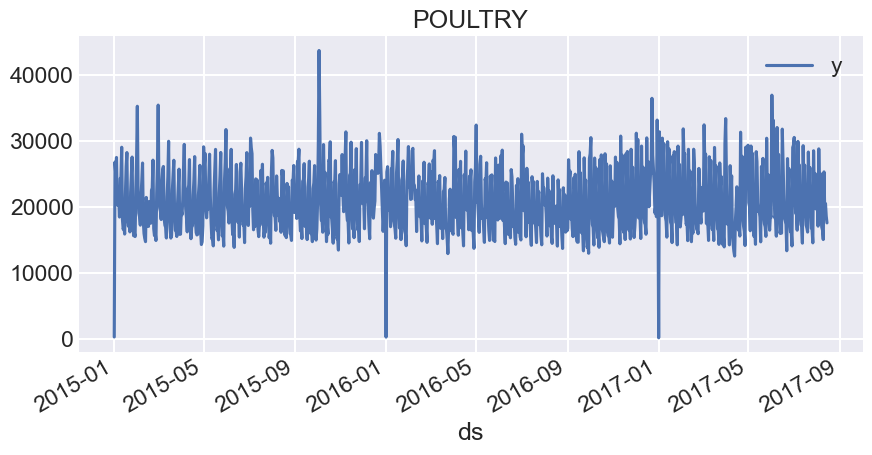

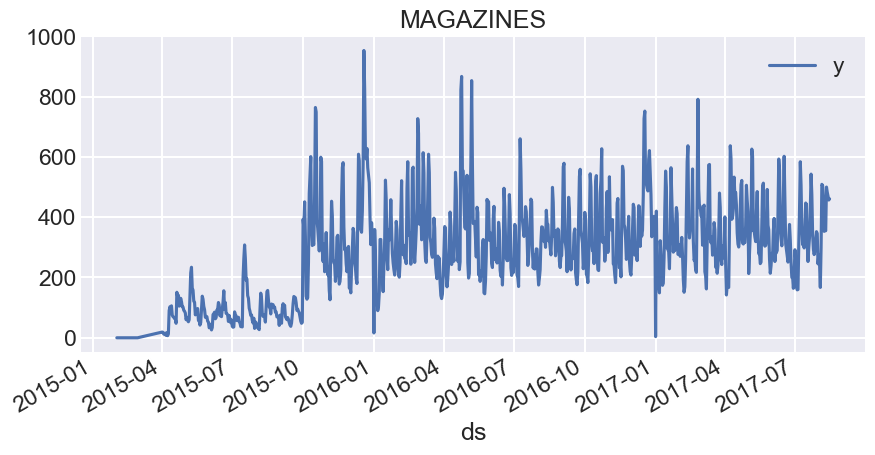

In [920]:
fam_ts = new_df.filter(pl.col('family').is_in(new_df['family'].sample(n=4).unique())).sort('ds').group_by_dynamic(index_column='ds',
                     every='1d',
                     group_by='family')\
                     .agg(pl.col('y').sum())

for fam in fam_ts.to_pandas()['family'].unique():

    sub = fam_ts.filter(pl.col('family') == fam)

    sub.to_pandas().plot(figsize=(8,4),
    x='ds',
    y='y',
    title=fam)

    plt.show()

In [921]:
#lets model these events instead of handling them by imputation, they seem consistent and I thnk the model can learn these behaviors 

new_df = new_df.with_columns((
    pl.when(new_df['ds'].dt.week().is_in([52,1]))
    
    .then(1)
    
    .otherwise(0)).alias('end_of_year_lift')
)

In [922]:
df_ = new_df.drop('dcoilwtico','cluster','state','city','type','store_nbr','id','on_sale','family','is_zero') # we will lag the oil price as not to leak data and simply leave our all categories for now


df_.head()

shape: (5, 26)
┌────────────┬─────┬─────────────┬──────────────┬───┬─────────┬─────────┬────────────┬─────────────┐
│ ds         ┆ y   ┆ onpromotion ┆ unique_id    ┆ … ┆ cos2_84 ┆ cos3_84 ┆ is_holiday ┆ end_of_year │
│ ---        ┆ --- ┆ ---         ┆ ---          ┆   ┆ ---     ┆ ---     ┆ ---        ┆ _lift       │
│ date       ┆ f64 ┆ i64         ┆ str          ┆   ┆ f32     ┆ f32     ┆ i64        ┆ ---         │
│            ┆     ┆             ┆              ┆   ┆         ┆         ┆            ┆ i32         │
╞════════════╪═════╪═════════════╪══════════════╪═══╪═════════╪═════════╪════════════╪═════════════╡
│ 2015-07-01 ┆ 0.0 ┆ 0           ┆ HOME APPLIAN ┆ … ┆ -0.5    ┆ -1.0    ┆ 0          ┆ 0           │
│            ┆     ┆             ┆ CES-store_1  ┆   ┆         ┆         ┆            ┆             │
│ 2015-07-01 ┆ 0.0 ┆ 0           ┆ HOME APPLIAN ┆ … ┆ -0.5    ┆ -1.0    ┆ 0          ┆ 0           │
│            ┆     ┆             ┆ CES-store_10 ┆   ┆         ┆         ┆            ┆             │
│ 2015-07-01 ┆ 0.0 ┆ 0           ┆ HOME APPLIAN ┆ … ┆ -0.5    ┆ -1.0    ┆ 0          ┆ 0           │
│            ┆     ┆             ┆ CES-store_11 ┆   ┆         ┆         ┆            ┆             │
│ 2015-07-01 ┆ 0.0 ┆ 0           ┆ HOME APPLIAN ┆ … ┆ -0.5    ┆ -1.0    ┆ 0          ┆ 0           │
│            ┆     ┆             ┆ CES-store_12 ┆   ┆         ┆         ┆            ┆             │
│ 2015-07-01 ┆ 0.0 ┆ 0           ┆ HOME APPLIAN ┆ … ┆ -0.5    ┆ -1.0    ┆ 0          ┆ 0           │
│            ┆     ┆             ┆ CES-store_13 ┆   ┆         ┆         ┆            ┆             │
└────────────┴─────┴─────────────┴──────────────┴───┴─────────┴─────────┴────────────┴─────────────┘

In [923]:
mlf_cv = mlf.cross_validation(df= df_, #backtest on just continous features 
                     h=horizon,
                     step_size=horizon,
                     n_windows=3,
                     as_numpy=True,
                     static_features=[],
                     refit=False) # no refit, we are looking to quickly evaluate performance... 

In [924]:
display(eval_tab_gen(mlf_cv,model_name = 'ml_all_feats_'))

/var/folders/k6/3y0j37d96lqf05r_8yyfcqvh0000gn/T/ipykernel_60116/2825148325.py:32: DeprecationWarning:

`DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`

/var/folders/k6/3y0j37d96lqf05r_8yyfcqvh0000gn/T/ipykernel_60116/2825148325.py:32: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



rmse        mae      wape  forecast_bias
ml_all_feats_RandomForest  264.071123  78.675337  0.167362      -4.519262
ml_all_feats_catboost      250.371515  72.226931  0.153645      -2.089723
ml_all_feats_lgbm          249.359722  71.932773  0.153019      -3.989638
ml_all_feats_xgb           264.394844  74.758045  0.159029      -3.326552

In [925]:
# it looks like fourier feats don't add anything to the model, lets try utilizing some of our external features, (oil) we already have promotions in the models 
from mlforecast.lag_transforms import RollingQuantile
from mlforecast.feature_engineering import transform_exog 
from utilsforecast.preprocessing import fill_gaps 

oil = data_dict['oil']

oil_fill = fill_gaps(oil.with_columns(
    (pl.lit(1)).alias('unique_id'))

                     .rename({'date':'ds'}),

                     freq='1d').interpolate()

oil_feats = transform_exog(oil_fill,
               lags = [1,2,3],
               lag_transforms = {1:[#RollingMean(window_size=7,min_samples=1), # use rolling quantiles and stds to capture oil price variability. 
                                    RollingStd(window_size=3,min_samples=1),
                                    RollingStd(window_size=7,min_samples=1),
                                   RollingQuantile(window_size=7,p=.9,min_samples=1),
                                   RollingQuantile(window_size=7,p=.1,min_samples=1)]})


#lets join to our dataframe 
df_and_oil = df_.select(pl.all().exclude(pl.Float32)).join(oil_feats,
                                              on=['ds']).drop('dcoilwtico','unique_id_right')


df_and_oil.head()

shape: (5, 13)
┌────────────┬─────┬────────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ ds         ┆ y   ┆ onpromotio ┆ unique_id  ┆ … ┆ dcoilwtico ┆ dcoilwtico ┆ dcoilwtic ┆ dcoilwtic │
│ ---        ┆ --- ┆ n          ┆ ---        ┆   ┆ _rolling_s ┆ _rolling_s ┆ o_rolling ┆ o_rolling │
│ date       ┆ f64 ┆ ---        ┆ str        ┆   ┆ td_lag1_wi ┆ td_lag1_wi ┆ _quantile ┆ _quantile │
│            ┆     ┆ i64        ┆            ┆   ┆ …          ┆ …          ┆ _la…      ┆ _la…      │
│            ┆     ┆            ┆            ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│            ┆     ┆            ┆            ┆   ┆ f64        ┆ f64        ┆ f64       ┆ f64       │
╞════════════╪═════╪════════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 2015-07-01 ┆ 0.0 ┆ 0          ┆ HOME APPLI ┆ … ┆ 0.583156   ┆ 0.568701   ┆ 59.758    ┆ 58.554    │
│            ┆     ┆            ┆ ANCES-stor ┆   ┆            ┆            ┆           ┆           │
│            ┆     ┆            ┆ e_1        ┆   ┆            ┆            ┆           ┆           │
│ 2015-07-01 ┆ 0.0 ┆ 0          ┆ HOME APPLI ┆ … ┆ 0.583156   ┆ 0.568701   ┆ 59.758    ┆ 58.554    │
│            ┆     ┆            ┆ ANCES-stor ┆   ┆            ┆            ┆           ┆           │
│            ┆     ┆            ┆ e_10       ┆   ┆            ┆            ┆           ┆           │
│ 2015-07-01 ┆ 0.0 ┆ 0          ┆ HOME APPLI ┆ … ┆ 0.583156   ┆ 0.568701   ┆ 59.758    ┆ 58.554    │
│            ┆     ┆            ┆ ANCES-stor ┆   ┆            ┆            ┆           ┆           │
│            ┆     ┆            ┆ e_11       ┆   ┆            ┆            ┆           ┆           │
│ 2015-07-01 ┆ 0.0 ┆ 0          ┆ HOME APPLI ┆ … ┆ 0.583156   ┆ 0.568701   ┆ 59.758    ┆ 58.554    │
│            ┆     ┆            ┆ ANCES-stor ┆   ┆            ┆            ┆           ┆           │
│            ┆     ┆            ┆ e_12       ┆   ┆            ┆            ┆           ┆           │
│ 2015-07-01 ┆ 0.0 ┆ 0          ┆ HOME APPLI ┆ … ┆ 0.583156   ┆ 0.568701   ┆ 59.758    ┆ 58.554    │
│            ┆     ┆            ┆ ANCES-stor ┆   ┆            ┆            ┆           ┆           │
│            ┆     ┆            ┆ e_13       ┆   ┆            ┆            ┆           ┆           │
└────────────┴─────┴────────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

In [926]:
df_and_oil = df_and_oil.with_columns( # capture weekly promotional activity using a rollign sum, we don't need to lag this feature given we know promotional events in the future 
    
    (pl.col('onpromotion')
     
     .rolling_sum(window_size=7,
       
                  min_periods=1)
          
                  .over([pl.col('unique_id')]) #partition by unique id 
                                                              .alias('promotional_momentum')))

In [927]:
df_and_oil.head()

shape: (5, 14)
┌────────────┬─────┬────────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ ds         ┆ y   ┆ onpromotio ┆ unique_id  ┆ … ┆ dcoilwtico ┆ dcoilwtico ┆ dcoilwtic ┆ promotion │
│ ---        ┆ --- ┆ n          ┆ ---        ┆   ┆ _rolling_s ┆ _rolling_q ┆ o_rolling ┆ al_moment │
│ date       ┆ f64 ┆ ---        ┆ str        ┆   ┆ td_lag1_wi ┆ uantile_la ┆ _quantile ┆ um        │
│            ┆     ┆ i64        ┆            ┆   ┆ …          ┆ …          ┆ _la…      ┆ ---       │
│            ┆     ┆            ┆            ┆   ┆ ---        ┆ ---        ┆ ---       ┆ i64       │
│            ┆     ┆            ┆            ┆   ┆ f64        ┆ f64        ┆ f64       ┆           │
╞════════════╪═════╪════════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 2015-07-01 ┆ 0.0 ┆ 0          ┆ HOME APPLI ┆ … ┆ 0.568701   ┆ 59.758     ┆ 58.554    ┆ 0         │
│            ┆     ┆            ┆ ANCES-stor ┆   ┆            ┆            ┆           ┆           │
│            ┆     ┆            ┆ e_1        ┆   ┆            ┆            ┆           ┆           │
│ 2015-07-01 ┆ 0.0 ┆ 0          ┆ HOME APPLI ┆ … ┆ 0.568701   ┆ 59.758     ┆ 58.554    ┆ 0         │
│            ┆     ┆            ┆ ANCES-stor ┆   ┆            ┆            ┆           ┆           │
│            ┆     ┆            ┆ e_10       ┆   ┆            ┆            ┆           ┆           │
│ 2015-07-01 ┆ 0.0 ┆ 0          ┆ HOME APPLI ┆ … ┆ 0.568701   ┆ 59.758     ┆ 58.554    ┆ 0         │
│            ┆     ┆            ┆ ANCES-stor ┆   ┆            ┆            ┆           ┆           │
│            ┆     ┆            ┆ e_11       ┆   ┆            ┆            ┆           ┆           │
│ 2015-07-01 ┆ 0.0 ┆ 0          ┆ HOME APPLI ┆ … ┆ 0.568701   ┆ 59.758     ┆ 58.554    ┆ 0         │
│            ┆     ┆            ┆ ANCES-stor ┆   ┆            ┆            ┆           ┆           │
│            ┆     ┆            ┆ e_12       ┆   ┆            ┆            ┆           ┆           │
│ 2015-07-01 ┆ 0.0 ┆ 0          ┆ HOME APPLI ┆ … ┆ 0.568701   ┆ 59.758     ┆ 58.554    ┆ 0         │
│            ┆     ┆            ┆ ANCES-stor ┆   ┆            ┆            ┆           ┆           │
│            ┆     ┆            ┆ e_13       ┆   ┆            ┆            ┆           ┆           │
└────────────┴─────┴────────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

In [928]:
oil_cv = mlf.cross_validation(df = df_and_oil, #backtest on just continous features 
                     h=horizon,
                     step_size=horizon,
                     n_windows=3,
                     as_numpy=True,
                     static_features=[],
                     refit=False)


In [929]:
display(eval_tab_gen(oil_cv,model_name = 'oil_features_')) # it looks like numerous oil features improve accuracy 

/var/folders/k6/3y0j37d96lqf05r_8yyfcqvh0000gn/T/ipykernel_60116/2825148325.py:32: DeprecationWarning:

`DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`

/var/folders/k6/3y0j37d96lqf05r_8yyfcqvh0000gn/T/ipykernel_60116/2825148325.py:32: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



rmse        mae      wape  forecast_bias
oil_features_RandomForest  263.415038  78.190868  0.166332      -4.522756
oil_features_catboost      242.270296  70.246470  0.149432      -1.655359
oil_features_lgbm          250.891615  71.870753  0.152887      -3.866271
oil_features_xgb           245.282850  70.112941  0.149148      -2.294983

* now lets add some categorical features, and perform feature selection on all features...

In [930]:
df_all, _ = pipeline(df_and_oil,
         h=1,
        features=features,
        freq='1d')

In [931]:

# Calculate the split date for each ID
split_dates = (
    df_all.group_by("unique_id")
    .agg(pl.col("ds").max().alias("max_date"))
    .with_columns(pl.col("max_date").dt.offset_by(f'-{horizon * 2}d'))
)

#sanity checking split dates ^ 

from datetime import datetime

max_train_date = datetime(2017,7,16)

train = df_all.filter(pl.col('ds') < max_train_date)

min_test_date = datetime(2017,7,30)

val = df_all.filter((pl.col('ds') < min_test_date) & (pl.col('ds') >= max_train_date))

test = df_all.filter(pl.col('ds') > val['ds'].max())

print(f"Max Training Date: {train['ds'].max()}, Minumum Validation Date {val['ds'].min()}, Max Validation Date {val['ds'].max()}, Minimum Testing Date {test['ds'].min()}")

Max Training Date: 2017-07-15, Minumum Validation Date 2017-07-16, Max Validation Date 2017-07-29, Minimum Testing Date 2017-07-30


In [932]:
cat_feats = df.select(
          pl.col(pl.String)).unique()

train_cats = train.join(cat_feats,
           on='unique_id')

valid_cats = val.join(cat_feats,
                        on='unique_id')

test_cats = test.join(cat_feats,
                      on='unique_id')

In [933]:
# lets enable native categorical handling and re-evaluate 
cat_feats = ['store_nbr','family','city','state','type']

pre_df = mlf.preprocess(
    pl.concat([train_cats,valid_cats],how='vertical'), #concat to together, then resplit 
               static_features=cat_feats,
               ).select(pl.exclude(pl.Float32))


train_ = pre_df.filter(pl.col('ds') < valid_cats['ds'].min())

X_train = train_.drop('y','ds','unique_id')
y_train = train_.select(pl.col('y'))

val_ = pre_df.filter(pl.col('ds') >= valid_cats['ds'].min())

X_val = val_.drop('y','ds','unique_id')
y_val = val_.select(pl.col('y'))

In [934]:
import lightgbm as lgb 

X_train_p = X_train.to_pandas()

lgbr = LGBMRegressor(verbosity=-1,
                    random_state=42,
                    categorical_feature = [X_train_p.columns.get_loc(x) for x in cat_feats])

X_train_p[cat_feats] = X_train_p[cat_feats].astype('category')

* Using Select From Model and Recursive Feature Addition to prune unimportant features.

In [935]:
from sklearn.feature_selection import SelectFromModel
from feature_engine.selection import RecursiveFeatureAddition
from sklearn.model_selection import TimeSeriesSplit
from sklearn import set_config 
from catboost import Pool
from sklearn.pipeline import make_pipeline

set_config(transform_output='pandas')

def top_percentile_callable(X, percentile=80):
    """
    Callable function to select top features based on a given percentile.
    
    Parameters:
    X (array-like): Feature matrix.
    percentile (float): Percentile to select.
    
    Returns:
    int: Number of features to select.
    """
    num_features = X.shape[1]
    return int(np.ceil(num_features * (percentile / 100)))

select_best = SelectFromModel(estimator=lgbr,
                              prefit=False,
                              threshold=.0001) # arbitrary threshold for feature importances 

ts_cv = TimeSeriesSplit(n_splits=3,gap=0) # create timeseries splitter 

#feature selection 
sfs = RecursiveFeatureAddition(lgbr,
                         cv = ts_cv,
                         scoring='neg_root_mean_squared_error',
                        )

feature_selector = make_pipeline(select_best,
                                 sfs)

X_new = feature_selector.fit_transform(X_train_p,
                                  y_train.to_pandas()).infer_objects() # we dropped 2 features here 

#pull features into list 

feats_to_keep = X_new.columns.tolist()

print(f'List of Features we are keeping, via a Greedy Search: {feats_to_keep}')

/opt/anaconda3/envs/my_env/lib/python3.9/site-packages/lightgbm/basic.py:2118: UserWarning:

categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.

/opt/anaconda3/envs/my_env/lib/python3.9/site-packages/lightgbm/basic.py:2118: UserWarning:

categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.

/opt/anaconda3/envs/my_env/lib/python3.9/site-packages/lightgbm/basic.py:2118: UserWarning:

categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.

/opt/anaconda3/envs/my_env/lib/python3.9/site-packages/lightgbm/basic.py:2118: UserWarning:

categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the D

List of Features we are keeping, via a Greedy Search: ['onpromotion', 'dcoilwtico_lag1', 'dcoilwtico_lag3', 'promotional_momentum', 'store_nbr', 'family', 'city', 'state', 'type', 'lag1', 'lag3', 'lag7', 'lag28', 'rolling_mean_lag1_window_size7_min_samples1', 'quarter', 'weekday', 'day']


In [936]:
imp_cats = X_new.select_dtypes('category').columns.tolist()

X_val_ = X_val.to_pandas()[feats_to_keep]
X_val_[imp_cats] = X_val_[imp_cats].astype('category')


#create date arrays as integer representation for catboost 
train_dates = train_['ds'].cast(pl.Int64).to_numpy()
val_dates = val_['ds'].cast(pl.Int64).to_numpy()


#prepare Pool objects for Catboost
cb_train = Pool(data=X_new,
                label=y_train.to_numpy(),
                cat_features = imp_cats,
                feature_names = feats_to_keep,
                timestamp = train_dates)

cb_val = Pool(data=X_val_,
              label=y_val.to_numpy(),
                cat_features = imp_cats,
                feature_names = feats_to_keep,
                timestamp = val_dates)


cbr = CatBoostRegressor(
    random_state=42,
   # max_depth=10,
    od_type='Iter',
    od_wait=100,
    eval_metric='RMSE'
)

# cbr.fit(cb_train,eval_set = cb_val,plot=True,use_best_model=True)


In [937]:
# #slice x for columns and convert y_train to numpy 
# X_train_ = X_train_p[feats_to_keep].to_numpy()
# y_train_ = y_train.to_numpy()


# import optuna 
# #TUNE MODEL with TSCV 
# def objective(trial):
#     # Define hyperparameters to be tuned
#     params = {
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 1e+5, log=True),
#         'border_count': trial.suggest_int('border_count', 32, 255),
#         'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bernoulli', 'MVS']),
#         'max_depth':trial.suggest_int('max_depth',3,12)
#     }

#     # Create and train the model
#     model = CatBoostRegressor(
#         **params,
#         iterations=cbr.best_iteration_,
#         eval_metric="RMSE"
#     )


#     model.fit(cb_train,eval_set=cb_val, verbose=0)

#     # Predict and evaluate
#     y_pred = model.predict(X_val_)
    
#     rmse = root_mean_squared_error(y_pred, y_val.to_numpy())
    
#     # Return the combined metric to minimize
#     return rmse

# def main():
#     # Create an Optuna study object
#     study = optuna.create_study(direction='minimize')  # Minimize RMSE
#     study.optimize(objective, n_trials=30)  # Number of trials

#     # Print the best hyperparameters and corresponding RMSE
#     print('Best parameters:', study.best_params)
#     print('Best RMSE:', study.best_value)

# if __name__ == "__main__":
#     main()

In [938]:
# Best parameters: {'l2_leaf_reg': 5.64307441719962, 'border_count': 235, 'bootstrap_type': 'MVS', 'max_depth': 11}
# Best RMSE: 197.52850497690144
#best iteration = 188

catboost_params = {
'l2_leaf_reg': 5.64307441719962,
'border_count': 235, 
'bootstrap_type': 'MVS', 
'max_depth': 11,
 'od_wait': 10,
 'od_type': 'Iter',
 'thread_count': 8,
 'eval_metric': 'RMSE',
 'random_state': 42,
 'iterations':188,
 'verbose':50}


cbr = CatBoostRegressor(**catboost_params)

cbr.fit(cb_train,eval_set=cb_val)

0:	learn: 1232.8810477	test: 1240.0702680	best: 1240.0702680 (0)	total: 471ms	remaining: 1m 28s
50:	learn: 421.6267605	test: 347.2329077	best: 347.2329077 (50)	total: 19.4s	remaining: 52.1s
100:	learn: 301.1069729	test: 209.0873576	best: 209.0873576 (100)	total: 34.3s	remaining: 29.5s
150:	learn: 277.4242759	test: 196.0541977	best: 196.0541977 (150)	total: 49s	remaining: 12s
187:	learn: 269.0888235	test: 195.0520763	best: 195.0520763 (187)	total: 59s	remaining: 0us

bestTest = 195.0520763
bestIteration = 187



In [939]:
test_pre = mlf.preprocess(
    pl.concat([train_cats,valid_cats,test_cats],how='vertical'), #concat to together, then resplit 
               static_features=cat_feats,
               )\
               .filter(pl.col('ds') >= test['ds'].min())

y_test = test_pre.select(pl.col('y')).to_numpy()

X_test = test_pre.drop('y','ds','unique_id').to_pandas()[feats_to_keep]

* evaluate test set performance, keep in mind we tuned on the validation set, but havent used that data for training.

In [940]:
cb_pred_val = cbr.predict(X_val_)

val_score = root_mean_squared_error(y_val.to_numpy(),cb_pred_val)

cb_pred_test = cbr.predict(X_test)

for metric in [root_mean_squared_error, mean_absolute_error]: 
    
    print(metric(y_test,cb_pred_test))

226.95220142066682
72.03758247187024


In [941]:
from utilsforecast.losses import *

error_dist = (test_pre
              
   .with_columns(y_pred = cb_pred_test)

   .to_pandas()

   .groupby('unique_id').apply(eval_func))

/var/folders/k6/3y0j37d96lqf05r_8yyfcqvh0000gn/T/ipykernel_60116/2825148325.py:9: RuntimeWarning:

divide by zero encountered in scalar divide

/var/folders/k6/3y0j37d96lqf05r_8yyfcqvh0000gn/T/ipykernel_60116/2825148325.py:13: RuntimeWarning:

divide by zero encountered in scalar divide

/var/folders/k6/3y0j37d96lqf05r_8yyfcqvh0000gn/T/ipykernel_60116/2825148325.py:9: RuntimeWarning:

divide by zero encountered in scalar divide

/var/folders/k6/3y0j37d96lqf05r_8yyfcqvh0000gn/T/ipykernel_60116/2825148325.py:13: RuntimeWarning:

divide by zero encountered in scalar divide

/var/folders/k6/3y0j37d96lqf05r_8yyfcqvh0000gn/T/ipykernel_60116/2825148325.py:9: RuntimeWarning:

divide by zero encountered in scalar divide

/var/folders/k6/3y0j37d96lqf05r_8yyfcqvh0000gn/T/ipykernel_60116/2825148325.py:13: RuntimeWarning:

divide by zero encountered in scalar divide

/var/folders/k6/3y0j37d96lqf05r_8yyfcqvh0000gn/T/ipykernel_60116/2825148325.py:9: RuntimeWarning:

divide by zero encountered in scal

In [942]:
error_dist_ = pd.json_normalize(error_dist)\
    .set_index(error_dist.index)


error_tab = error_dist_.assign(family = error_dist_.index.str.split('-',expand=True).get_level_values(0),
                   store = error_dist_.index.str.split('-',expand=True).get_level_values(1)).reset_index(drop=True)

* lets compare catboost to naive methods by store/family, this can show us if naive may be better for some series

In [943]:
test_error = (test_pre

.group_by(['family','store_nbr'])

.agg(pl.col('y').sum())).join(pl.DataFrame(error_tab),
                              
                              right_on=['family','store'],

                                         left_on=['family','store_nbr']).sort('y',descending=True)


stats_cv_new = (stats_cv
 .with_columns(pl.col('unique_id')
                      .str.split_exact('-',n=1))
                      .unnest('unique_id').rename(
                          {'field_0':'family',
                           'field_1':'store_nbr'}
                      )
                      
                      .filter(pl.col('ds') >= test_pre['ds'].min()))

stat_error = (stats_cv_new.drop('ds',
                  'cutoff').unpivot(index = ['family','store_nbr','y'],
                                         
                     variable_name='model',

                     value_name='y_pred').to_pandas()

                     .groupby(['model','family','store_nbr'])

.apply(lambda x: root_mean_squared_error(x['y'],x['y_pred']))).reset_index(name='rmse')


catboost_eval = (test_error.drop('y')

    .unpivot(index=['family','store_nbr'],
             
                   variable_name='metric',

                   value_name='error')

                   .filter(pl.col('metric') == 'rmse')
                   
                   .with_columns(pl.lit('catboost').alias('model')))


#combine dataframe 
comp_error = pl.concat([catboost_eval.drop('metric')
           
           .rename({'error':'rmse'}),
           
           pl.DataFrame(stat_error)
           
           .select(pl.col('family','store_nbr','rmse','model'))
           ],
           how='vertical_relaxed')


/var/folders/k6/3y0j37d96lqf05r_8yyfcqvh0000gn/T/ipykernel_60116/14042886.py:22: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [944]:

px.box(
    comp_error,
    y='family',
    x='rmse',
    color='model',
    orientation='h',
    title='Monthly Naive vs Catboost RMSE Distribution',
    labels={'error':'Root Mean Squared Error',
           'family':'Product Family'}
)

In [945]:
# it looks like in many low-volume categories monthly naive is outperforming catboost

# the plan is to utilize monthly naive on the low-volume series and catboost on the higher volume series

opt_model = (comp_error

 .sort(by=['family','store_nbr','rmse'])
 
 .group_by(['family','store_nbr'])
 
 .first()).select(pl.col('family','store_nbr','model'))

In [946]:
opt_model['model'].value_counts() # wow, we can craft a diverse ensemble here 

shape: (5, 2)
┌───────────────────┬───────┐
│ model             ┆ count │
│ ---               ┆ ---   │
│ str               ┆ u32   │
╞═══════════════════╪═══════╡
│ single_step_naive ┆ 342   │
│ monthly_naive     ┆ 352   │
│ catboost          ┆ 623   │
│ seasonal_exp      ┆ 126   │
│ weekly_naive      ┆ 339   │
└───────────────────┴───────┘

In [947]:
# lets see if we can devise an ensemble to improve performance using scipy, find optimal wts on val set and try them on test set 

pred_arr = (valid_cats   
                   
   .with_columns(y_pred = cb_pred_val)

    .select('ds','y','y_pred','unique_id')

    .rename({'y_pred':'catboost'})
    
    .join(stats_cv.drop('cutoff','y'),
          
          on=['unique_id','ds'])
          
          .with_columns(pl.col('unique_id')
                      .str.split_exact('-',n=1))
                      .unnest('unique_id').rename(
                          {'field_0':'family',
                           'field_1':'store_nbr'}
                      )).with_columns(unique_id = pl.col('family') + '-' + pl.col('store_nbr'))

In [948]:
from scipy.optimize import minimize 

def objective(weights, model_preds, y_true):
    # Ensure weights are non-negative and sum to 1
    weights = np.clip(weights, 0, None)
    weights /= np.sum(weights)
    
    # Weighted predictions
    weighted_preds = np.dot(model_preds, weights)
    
    # Calculate MSE
    rmse = root_mean_squared_error(y_true, weighted_preds)

    return rmse

# lets create ensemble weights for each product family, I am afraid that each unique id would overfit badly 

pred_matrix = pred_arr.select('catboost','monthly_naive','weekly_naive','single_step_naive','seasonal_exp')

wts_array = np.array([.2,.2,.2,.2,.2])

bounds = [(0,1)] * len(wts_array)

# Define constraint that weights must sum to 1
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

# Optimize
result = minimize(objective, wts_array, args=(pred_matrix,pred_arr['y'].to_numpy()),
                bounds=bounds, constraints=constraints,method='SLSQP')

#print scores per family 
new_preds = np.dot(pred_matrix,result.x)

old_rmse = root_mean_squared_error(pred_arr['y'].to_numpy(),pred_arr['catboost'].to_numpy())

#print(f'BEFORE AND AFTER ENSEMBLE WEIGHTED ERROR: {uid}')
#print()

new_rmse = root_mean_squared_error(pred_arr['y'].to_numpy(),new_preds)

print(f'% reduction in RMSE by ensembling: {(1 - (new_rmse/old_rmse)) * 100:.2f}')

print(f'Old RMSE: {old_rmse}, New RMSE: {new_rmse}')

% reduction in RMSE by ensembling: 3.07
Old RMSE: 198.07023268057227, New RMSE: 191.98220582915002


In [949]:
# wow ensembling seems to provide a real advantage..... lets see if that generalizes to the test set 

test_preds = (test_pre.with_columns(y_pred = cb_pred_test)

    .select('ds','y','y_pred','unique_id')

    .rename({'y_pred':'catboost'})
    
    .join(stats_cv.drop('cutoff','y'),
          
          on=['unique_id','ds'])
          
          .with_columns(pl.col('unique_id')
                      .str.split_exact('-',n=1))
                      .unnest('unique_id').rename(
                          {'field_0':'family',
                           'field_1':'store_nbr'}
                      )).with_columns(unique_id = pl.col('family') + '-' + pl.col('store_nbr'))


test_pred_arr = test_preds.select('catboost','seasonal_exp',
                  'single_step_naive',
                  'monthly_naive','weekly_naive').to_numpy()

test_preds = test_preds.with_columns(wtd_preds = np.dot(test_pred_arr,result.x))


catboost_rmse = root_mean_squared_error(test_preds['y'].to_numpy(),test_preds['catboost'].to_numpy())

wtd_rmse = root_mean_squared_error(test_preds['y'].to_numpy(),test_preds['wtd_preds'].to_numpy())

print(f'Test Set Performance... Catboost only RMSE: {catboost_rmse:.0f} Ensemble RMSE: {wtd_rmse}') # ensembling this way causes overfitting! 

Test Set Performance... Catboost only RMSE: 230 Ensemble RMSE: 246.72600513936874


* welp, I was correct in that we overfit, dang!

* we will roll with catboost, I am afraid choosing the best model for each series will also overfit or just bring unimpressive improvements (some series then couldn't react to promotional changes as well...)

* lets rerun our feature selection algorithm with the validation data...

In [950]:
new_data = pl.concat([train_cats,valid_cats]).select(pl.exclude(pl.Float32))

data = mlf.preprocess(new_data,
               static_features=[])

data = data.with_columns(pl.col(pl.String).cast(pl.Categorical))

new_feats = feature_selector.fit_transform(data.drop('y','ds','unique_id').to_pandas(),
                                           
                                           data['y'].to_numpy())

/opt/anaconda3/envs/my_env/lib/python3.9/site-packages/lightgbm/basic.py:2118: UserWarning:

categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.

/opt/anaconda3/envs/my_env/lib/python3.9/site-packages/lightgbm/basic.py:2118: UserWarning:

categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.

/opt/anaconda3/envs/my_env/lib/python3.9/site-packages/lightgbm/basic.py:2118: UserWarning:

categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.

/opt/anaconda3/envs/my_env/lib/python3.9/site-packages/lightgbm/basic.py:2118: UserWarning:

categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the D

In [951]:
new_pool = Pool(data=new_feats,
                label=np.concatenate([y_train.to_numpy(),y_val.to_numpy()]),
                cat_features = imp_cats,
                feature_names = new_feats.columns.tolist(),
                timestamp = np.concatenate([train_dates,val_dates]))

test_new = (test_pre

.select(new_feats.columns.tolist())

.with_columns(pl.col(pl.String).cast(pl.Categorical))

.to_pandas())


#fit and predict with model 
cbr.fit(new_pool)

y_pred = cbr.predict(test_new)

#predict on test set now with the validation set added to training/feature selection
test_error = (
    test_pre.select('y')
    
    .with_columns(y_pred = y_pred)
    
    )

test_rmse = root_mean_squared_error(test_error['y'].to_numpy(),test_error['y_pred'].to_numpy())

test_wape = wape(test_error['y'].to_numpy(),test_error['y_pred'].to_numpy())

0:	learn: 1233.0139960	total: 341ms	remaining: 1m 3s
50:	learn: 419.8068265	total: 15.5s	remaining: 41.7s
100:	learn: 299.4513754	total: 29.5s	remaining: 25.4s
150:	learn: 277.2039449	total: 43.1s	remaining: 10.6s
187:	learn: 268.2317675	total: 53s	remaining: 0us


In [952]:
print(f'Test Set Global Root Mean Squared Error: {test_rmse:.0f} Units, Test Set Global Weighted Abs Percentage Error: {test_wape * 100:.1f}%')

Test Set Global Root Mean Squared Error: 224 Units, Test Set Global Weighted Abs Percentage Error: 14.8%


In [953]:
# lets now compare test to actuals 

hist = pre_df.select('ds','unique_id','family','store_nbr','y')

#make val and test comp dataframe with  predictions
val_comp = (val_ .select('ds','unique_id','family','store_nbr','y')
    
    .with_columns(val_pred = cb_pred_val))

test_comp = (test_pre
 
 .select('ds','unique_id','family','store_nbr','y')
    
    .with_columns(test_pred = y_pred)
    
    )


total_comp = pl.DataFrame(pd.concat([hist.to_pandas(),val_comp.to_pandas(),test_comp.to_pandas()]))

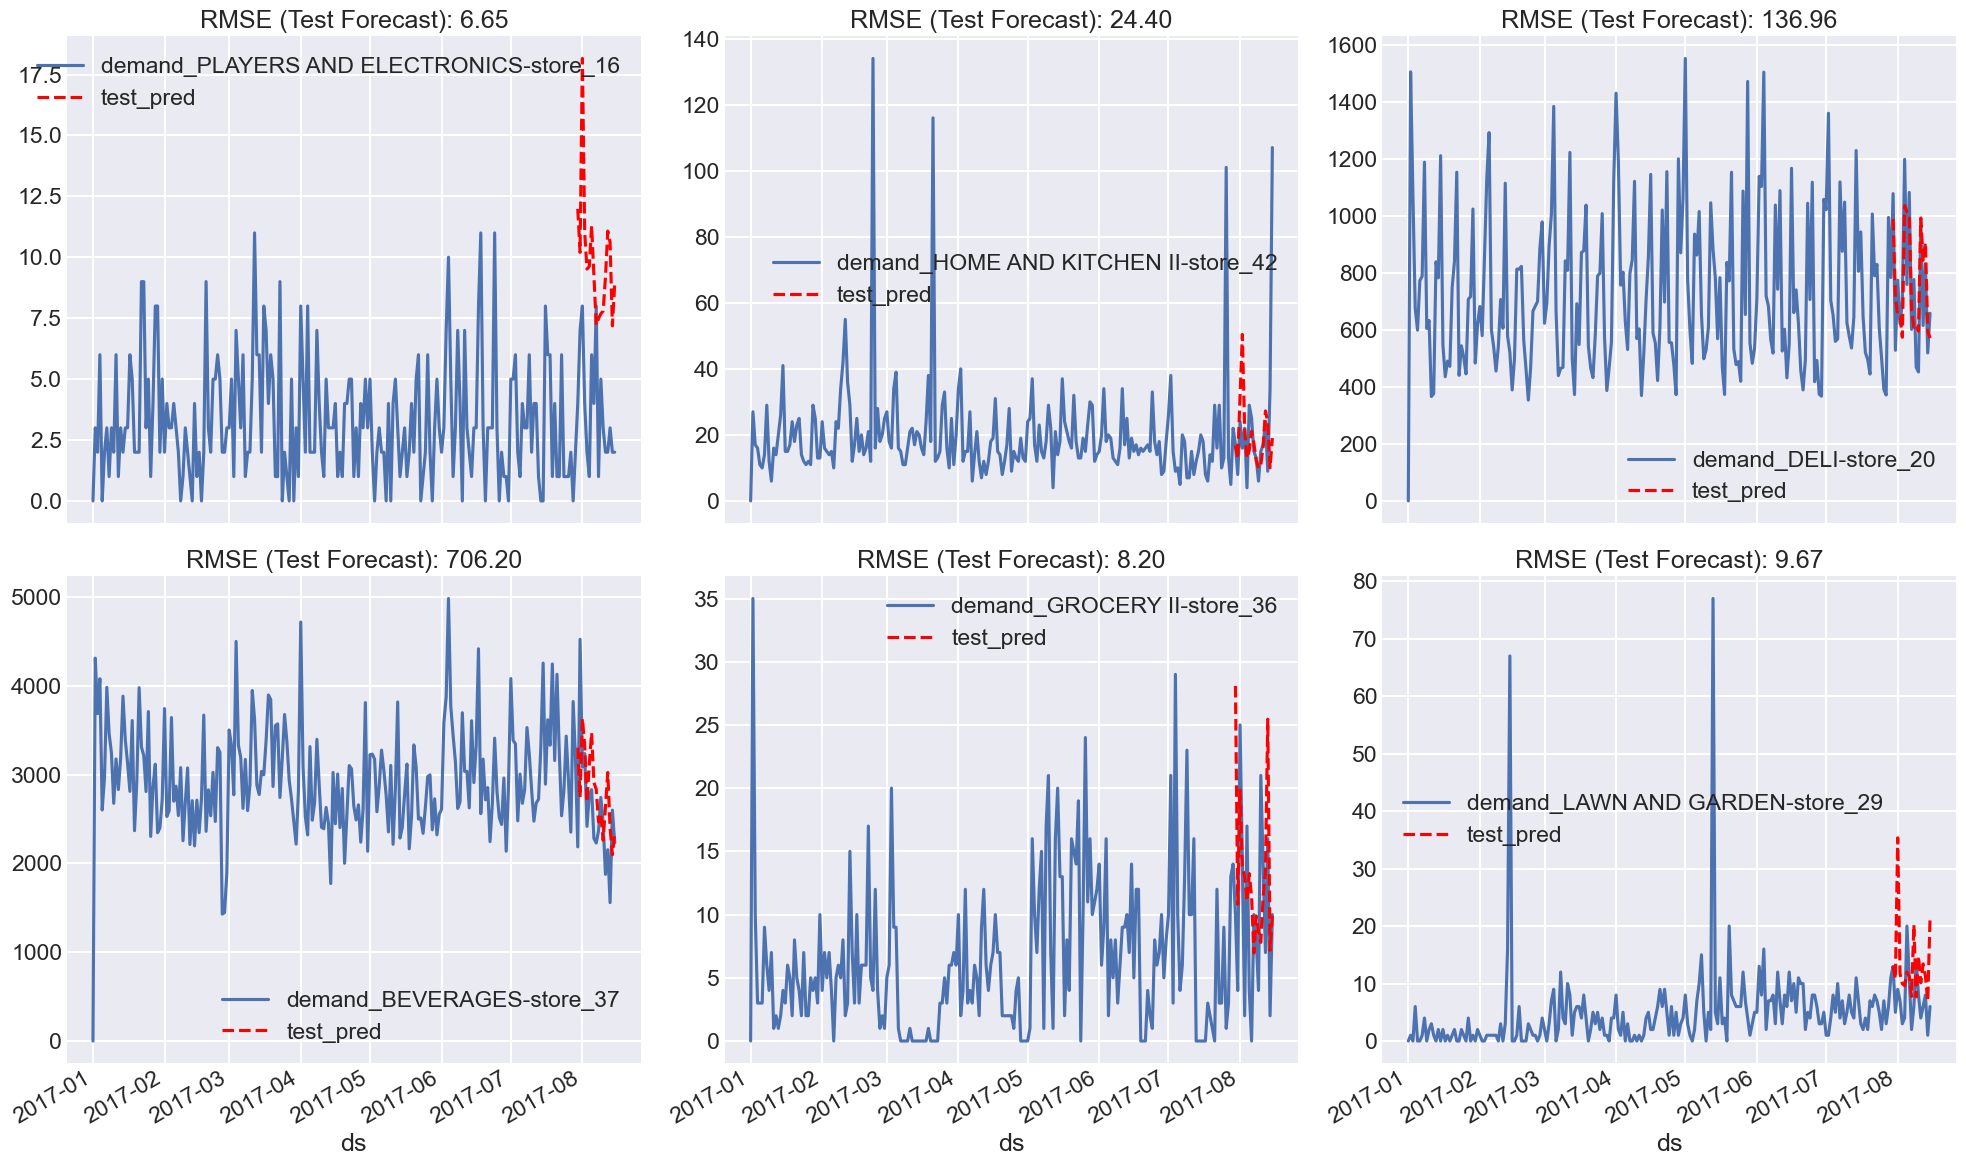

In [954]:
plt.style.use('seaborn-v0_8-darkgrid')


fig, ax = plt.subplots(figsize=(20,12),
ncols=3,
nrows=2,
sharex=True)

ax = ax.flatten() 

rand_ids = total_comp['unique_id'].sample(n=6)

for idx, id in enumerate(rand_ids): 

    (total_comp
     
     .filter((pl.col('unique_id') == id) &
              (pl.col('ds').dt.year() > 2016)).sort('ds')
     
     .to_pandas().set_index('ds')
     
     .plot(
           
           y=['y'],

           label=[f'demand_{id}'],
    
        linestyle='-',

           title=f'Demand for {id}',

           ax=ax[idx])
           
           )
    

    (total_comp
     
     .filter((pl.col('unique_id') == id) &
              (pl.col('ds').dt.year() > 2016)).sort('ds')
     
     .to_pandas().set_index('ds')
     
     .plot(
           
           y=['test_pred'],

           title=f'Demand for {id}',

           ax=ax[idx],

           color='red',
           
           linestyle='--')
           
           )
    
    score = (total_comp
     
     .filter((pl.col('unique_id') == id) &
              (pl.col('ds').dt.year() > 2016)).sort('ds')
     
     .to_pandas()).dropna(subset=['y','test_pred'])\
        .pipe(lambda x: root_mean_squared_error(x['y'],x['test_pred']))
    
    ax[idx].set_title(f'RMSE (Test Forecast): {score:.2f}')
    
fig.tight_layout()

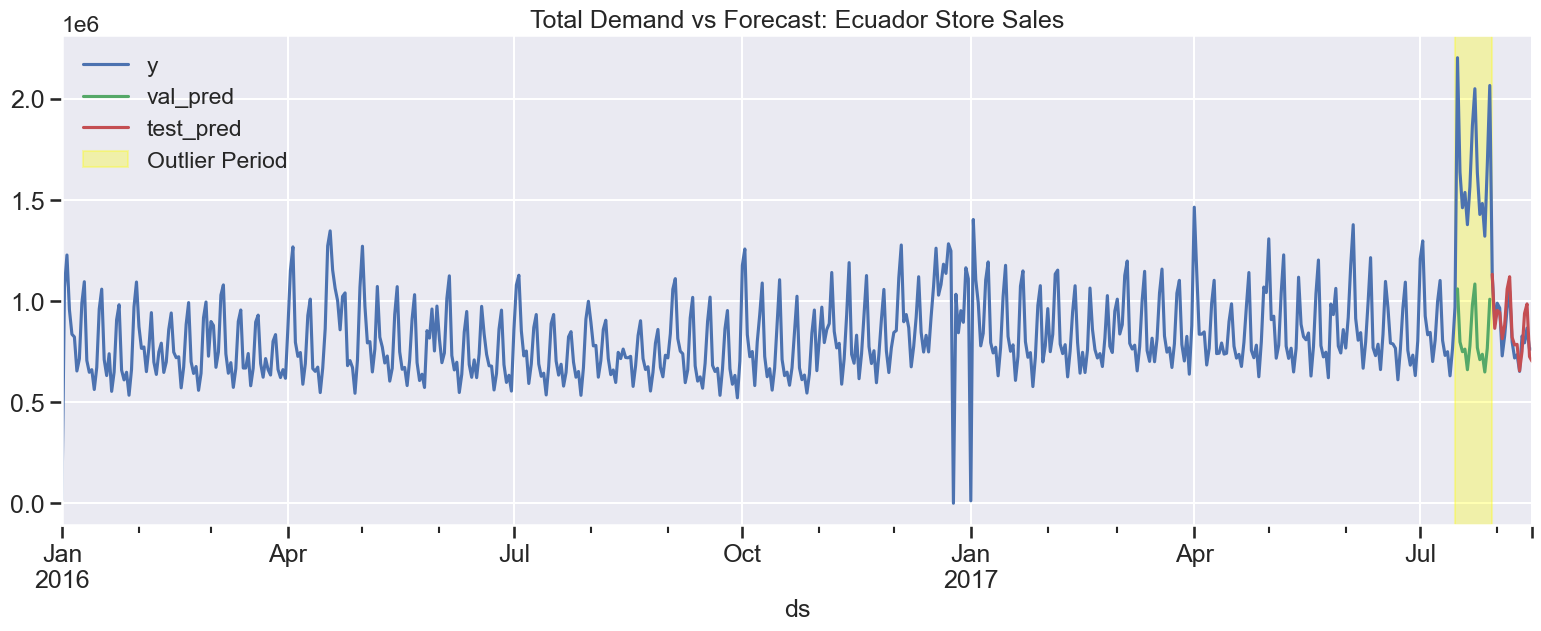

In [955]:
sns.set_context('talk')

ax = (total_comp.sort('ds')
     
     .to_pandas().set_index('ds')

     .resample('d').sum().loc['2016':]
     
     .plot(
           
           y=['y'],
    
        linestyle='-',
        
        figsize=(15,5),
        
        title='Total Demand vs Forecast: Ecuador Store Sales',
        fontsize=18)
           
           )


(total_comp.sort('ds')
     
     .to_pandas().set_index('ds').loc['2016':]

     .resample('d').sum(min_count=1)
     
     .plot(
           
           y=['val_pred','test_pred'],
    
        linestyle='-',

        ax = ax)
           
           )

# Highlight the outlier region
ax.axvspan(pd.Timestamp('2017-07-15'), 
           
           pd.Timestamp('2017-07-30'),

            color='yellow', alpha=0.3,

           label='Outlier Period')

plt.legend()

# Forecasting Out Of Sample. 

* thankfully we are given a test data set with all of our relevent fields included to to forecast (we know promotions and oil price)

In [956]:
#join categorical features to the data and cast 
pre_df_new = (df_all.select(pl.exclude(pl.Float32))
 
 .join(

df.select(pl.col(pl.String)).unique(),

on='unique_id'
)
.with_columns(pl.col(pl.String).cast(pl.Categorical))

)

In [957]:
#DEFINE NEW MLF (we only are using this for the make future dataframe capabilities 

mlf_new = MLForecast(models={'catboost': CatBoostRegressor(
    **catboost_params,
    cat_features = imp_cats
)},

             freq='d',
             
    lags=[1,2,3,7,28],
    lag_transforms={
        1: [RollingMean(window_size=7,
                        min_samples=1)
            ]
    }, # supplying my own date feature pipeline
    date_features=['quarter',
                   'month',
                   'weekday',
                   'day'
                  #end_of_year
                   ],)

col_select = [x for x in pre_df_new.columns if x in new_feats.columns] + ['ds','unique_id','y']

mlf_new.fit(pre_df_new.to_pandas()[col_select],
        static_features=imp_cats)

0:	learn: 1233.2906003	total: 461ms	remaining: 1m 26s
50:	learn: 419.7322938	total: 16.5s	remaining: 44.3s
100:	learn: 298.9750150	total: 32s	remaining: 27.6s
150:	learn: 275.4153748	total: 47.4s	remaining: 11.6s
187:	learn: 266.6700085	total: 59.6s	remaining: 0us


MLForecast(models=[catboost], freq=d, lag_features=['lag1', 'lag2', 'lag3', 'lag7', 'lag28', 'rolling_mean_lag1_window_size7_min_samples1'], date_features=['quarter', 'month', 'weekday', 'day'], num_threads=1)

In [958]:
fut_exog = data_dict['test'].join(oil_feats.drop('dcoilwtico','unique_id'),
                       left_on='date',
                right_on='ds')

#create columns for our future exog dataframe             
fut_exog = fut_exog.with_columns(

    #rename store nbr 
    ('store_' + pl.col('store_nbr').cast(pl.String)).alias('store_nbr'),

    pl.when(fut_exog['date'].dt.week().is_in([52,1]))
    
    .then(1)
    
    .otherwise(0).alias('end_of_year_lift')).rename({'date':'ds'})


# #join in city and state of store 
new_exog = (fut_exog
    .join(
        df.select(pl.col(pl.String)).unique(),
        on=['store_nbr','family'],
    )

    .with_columns(pl.col(pl.String).cast(pl.Categorical)
)
)

# we don't need to pass our categoricals in our new dataframe, nixtla remembers them 
new_exog = (new_exog
 
 .select([x for x in new_exog.columns if x in new_feats.columns]
                 + ['ds','unique_id'])

                 .select(pl.exclude(pl.Categorical), pl.col('unique_id')))

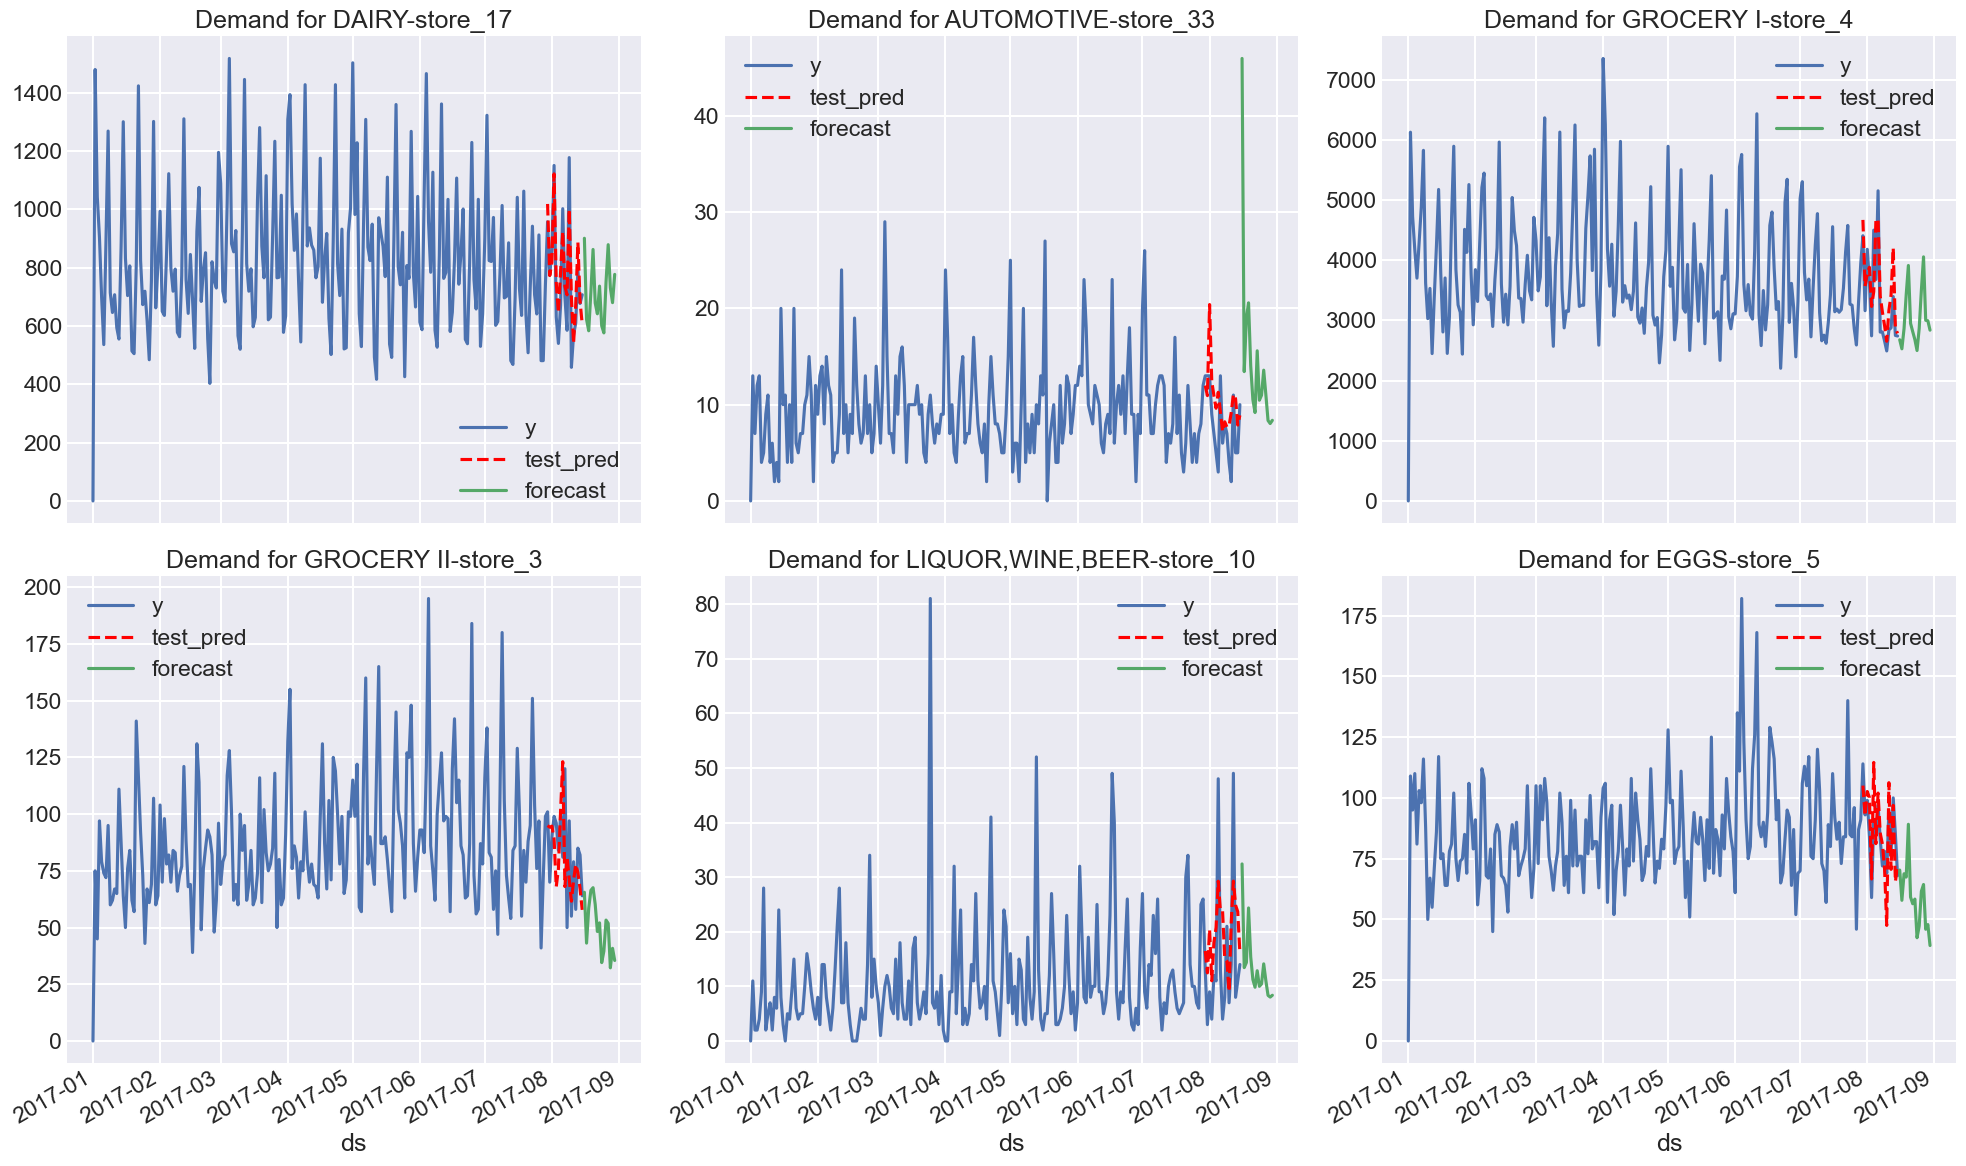

In [965]:
new_preds = mlf_new.predict(h=15,
            X_df = new_exog.to_pandas())

plt.style.use('seaborn-v0_8-darkgrid')


fig, ax = plt.subplots(figsize=(20,12),
ncols=3,
nrows=2,
sharex=True)

ax = ax.flatten() 

rand_ids = total_comp['unique_id'].sample(n=6)

for idx, id in enumerate(rand_ids): 

    (total_comp
     
     .filter((pl.col('unique_id') == id) &
              (pl.col('ds').dt.year() > 2016)).sort('ds')
     
     .to_pandas().set_index('ds')
     
     .plot(
           
           y=['y'],
    
        linestyle='-',

           title=f'Demand for {id}',

           ax=ax[idx])
           
           )
    

    (total_comp
     
     .filter((pl.col('unique_id') == id) &
              (pl.col('ds').dt.year() > 2016)).sort('ds')
     
     .to_pandas().set_index('ds')
     
     .plot(
           
           y=['test_pred'],

           title=f'Demand for {id}',

           ax=ax[idx],

           color='red',
           
           linestyle='--')
           
           )
    
    (new_preds.set_index('ds').query(f"unique_id == @id")
     
     .plot(y='catboost',
           
           label='forecast',

           ax=ax[idx]))
    
fig.tight_layout()

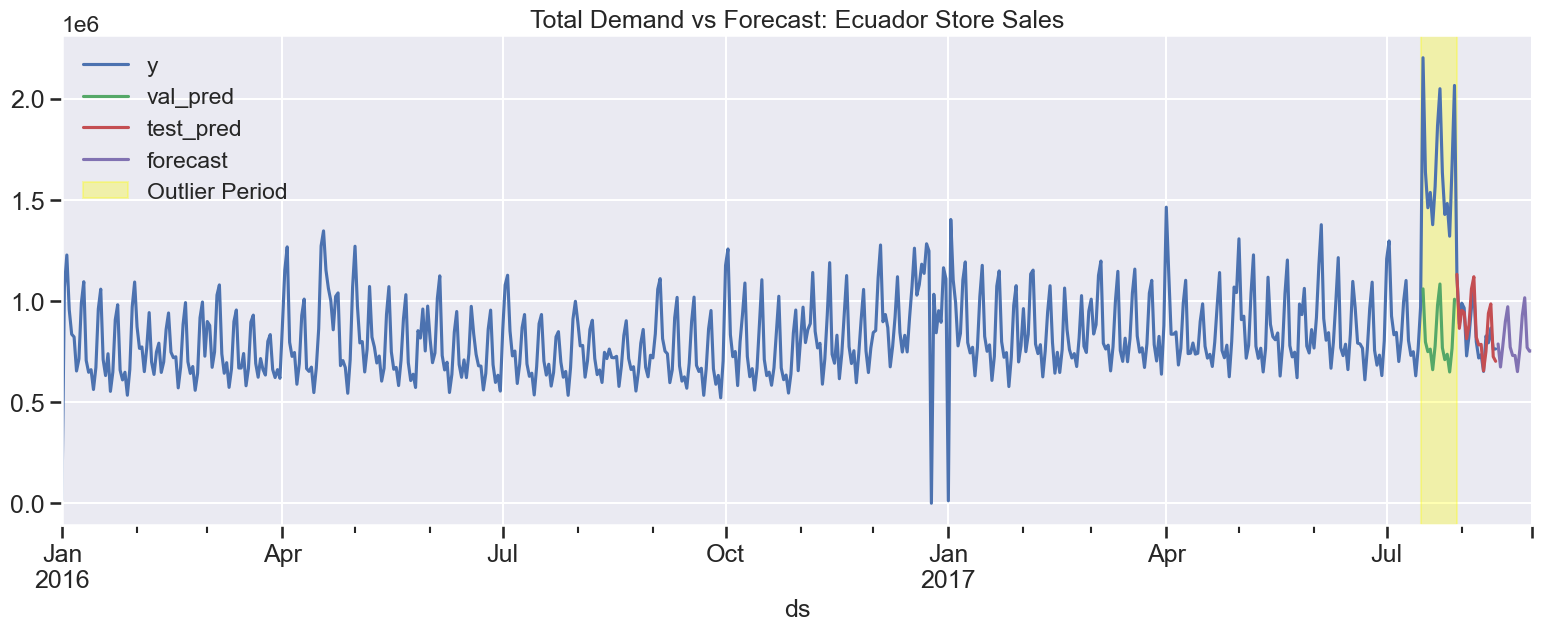

In [961]:
# finally lets inspect the final forecast at the top level 

sns.set_context('talk')

ax = (total_comp.sort('ds')
     
     .to_pandas().set_index('ds')

     .resample('d').sum().loc['2016':]
     
     .plot(
           
           y=['y'],
    
        linestyle='-',
        
        figsize=(15,5),
        
        title='Total Demand vs Forecast: Ecuador Store Sales',
        fontsize=18)
           
           )


(total_comp.sort('ds')
     
     .to_pandas().set_index('ds').loc['2016':]

     .resample('d').sum(min_count=1)
     
     .plot(
           
           y=['val_pred','test_pred'],
    
        linestyle='-',

        ax = ax)
           
           )

#plot out of sample predictions 
(new_preds.set_index('ds').resample('d').sum(numeric_only=True)
     
     .plot(y='catboost',
           
           label='forecast',

           ax=ax))

# Highlight the outlier region
ax.axvspan(pd.Timestamp('2017-07-15'), 
           
           pd.Timestamp('2017-07-30'),

            color='yellow', alpha=0.3,

           label='Outlier Period')

plt.legend()

In [966]:
data_dict['transactions']

shape: (83_488, 3)
┌────────────┬───────────┬──────────────┐
│ date       ┆ store_nbr ┆ transactions │
│ ---        ┆ ---       ┆ ---          │
│ date       ┆ i64       ┆ i64          │
╞════════════╪═══════════╪══════════════╡
│ 2013-01-01 ┆ 25        ┆ 770          │
│ 2013-01-02 ┆ 1         ┆ 2111         │
│ 2013-01-02 ┆ 2         ┆ 2358         │
│ 2013-01-02 ┆ 3         ┆ 3487         │
│ 2013-01-02 ┆ 4         ┆ 1922         │
│ …          ┆ …         ┆ …            │
│ 2017-08-15 ┆ 50        ┆ 2804         │
│ 2017-08-15 ┆ 51        ┆ 1573         │
│ 2017-08-15 ┆ 52        ┆ 2255         │
│ 2017-08-15 ┆ 53        ┆ 932          │
│ 2017-08-15 ┆ 54        ┆ 802          │
└────────────┴───────────┴──────────────┘

* things I would do differently... 

Try different ensembling approaches, unfortunately the scipy method overfit our data... 

Tune LGBM alongside catboost

Find other ways to clean the dataset, I feel the dataset still have timeseries that weren't relevant in it, ie they had way too many missing values/0s.

Utilize transactions dataset (their are surely some feature engineering opportunities there.)